#Toy prediction models
Here you can find simplified workflow created for the sake of a basic machine learning project lifecycle demo.

##Scope and use case
Let's create and evaluate machine learning models to **predict if a contact becomes our opportunity or customer** based on ~100 Hubspot numeric and categorical properties at the very beginning of user journey. Marketing and sales teams could apply these models to Hubspot accounts in order to get early conversion signals (instead of having to wait for intense enough engagement) and choose the leads of higher probability to convert to customers and opportunities.

##Metrics
We'll work with an imbalanced dataset (customers and opportunities don't exceed 29% of the dataset), so **accuracy** can not be used to measure model performance. Instead we need to measure **recall** (true positive rate; number of positive class predictions made out of all positive examples in the dataset) as well as check **confusion matrix** (visualization of true positives, true negatives, false positives and false negatives).

We'll also need to monitor data distribution shifts (especially beyond this demo).

#Gen AI model finetuning

##Set up Kernel, Load Required Dependencies, Dataset and LLM

In [1]:
!pip install --upgrade pip
!pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

!pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user
     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/887.5 MB 103.5 MB/s eta 0:00:07
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

###Load Dataset and LLM
You are going to continue experimenting with the DialogSum Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [3]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-c8fac5d84cd35861/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

Load the pre-trained FLAN-T5 model and its tokenizer directly from HuggingFace. Notice that you will be using the small version of FLAN-T5. Setting torch_dtype=torch.bfloat16 specifies the memory type to be used by this model.

In [4]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


###Test the Model with Zero Shot Inferencing
Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [6]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

##Perform Full Fine-Tuning

###Preprocess the Dialog-Summary Dataset
You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with Summarize the following conversation and to the start of the summary with Summary as follows:

Training prompt (dialogue):

Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.

Summary:
Training response (summary):

    Both Chris and Antje participated in the conversation.
Then preprocess the prompt-response dataset into tokens and pull out their input_ids (1 per token).

In [7]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

To save some time in the lab, you will subsample the dataset:

In [8]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Check the shapes of all three parts of the dataset:

In [9]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})


###Fine-Tune the Model with the Preprocessed Dataset
Now utilize the built-in Hugging Face Trainer class (see the documentation here). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [10]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training a fully fine-tuned version of the model would take a few hours on a GPU. To save time, download a checkpoint of the fully fine-tuned model to use in the rest of this notebook. This fully fine-tuned model will also be referred to as the instruct model in this lab.

In [ ]:
!aws s3 cp --recursive s3://dlai-generative-ai/models/flan-dialogue-summary-checkpoint/ ./flan-dialogue-summary-checkpoint/


The size of the downloaded instruct model is approximately 1GB.

In [ ]:
!ls -alh ./flan-dialogue-summary-checkpoint/pytorch_model.bin

Create an instance of the AutoModelForSeq2SeqLM class for the instruct model:

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("./flan-dialogue-summary-checkpoint", torch_dtype=torch.bfloat16)


###Evaluate the Model Qualitatively (Human Evaluation)
As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

###Evaluate the Model Quantitatively (with ROUGE Metric)
The ROUGE metric helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [ ]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

In [ ]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

The file data/dialogue-summary-training-results.csv contains a pre-populated list of all model results which you can use to evaluate on a larger section of data. Let's do that for each of the models:

In [ ]:
results = pd.read_csv("data/dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

The results show substantial improvement in all ROUGE metrics:

In [ ]:
print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

##Perform Parameter Efficient Fine-Tuning (PEFT)

 Now, let's perform Parameter Efficient Fine-Tuning (PEFT) fine-tuning as opposed to "full fine-tuning" as you did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon.

PEFT is a generic term that includes Low-Rank Adaptation (LoRA) and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request. The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

###Setup the PEFT/LoRA model for Fine-Tuning
You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (r) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

###Train PEFT Adapter

Define training arguments and create Trainer instance.

In [ ]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

Now everything is ready to train the PEFT adapter and save the model.

In [ ]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

That training was performed on a subset of data. To load a fully trained PEFT model, read a checkpoint of a PEFT model from S3.

In [ ]:
!aws s3 cp --recursive s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/ ./peft-dialogue-summary-checkpoint-from-s3/

In [ ]:
!ls -al ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin

Prepare this model by adding an adapter to the original FLAN-T5 model. You are setting is_trainable=False because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set is_trainable=True.

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       './peft-dialogue-summary-checkpoint-from-s3/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

The number of trainable parameters will be 0 due to is_trainable=False setting:

In [ ]:
print(print_number_of_trainable_model_parameters(peft_model))

###Evaluate the Model Qualitatively (Human Evaluation)
Make inferences for the same example as in sections 1.3 and 2.3, with the original model, fully fine-tuned and PEFT model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

###Evaluate the Model Quantitatively (with ROUGE Metric)
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the data/dialogue-summary-training-results.csv file. Load the values for the PEFT model now and check its performance compared to other models.

In [ ]:
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Now calculate the improvement of PEFT over a full fine-tuned model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).

#Churn prediction

##Data
###Installs and imports

In [ ]:
#@title Installs, imports, dataset loading
#@markdown Showing loaded dataset shape

In [ ]:

#from google.colab import drive
#drive.mount('/content/drive')

import os
import requests
import shutil
import pandas as pd
import json
import numpy as np

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', 510)
pd.options.display.max_rows = 400

#Supressing the warning messages (if any)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# We are using whitegrid style for our seaborn plots. This is like the most basic one
sns.set_style(style = 'whitegrid')

#Importing classifiers and help functions (params search, evaluation)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras import metrics as m
from sklearn import metrics
from sklearn.metrics import (average_precision_score, f1_score,
                             precision_recall_curve,roc_auc_score,accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
d__= pd.read_csv('/content/customers-type.csv')#'/content/customers-type.csv')
d__['Type'] = 'Customer'
#d = pd.read_csv('/content/drive/MyDrive/Tyk/test__.csv')#'/content/drive/MyDrive/test_.csv')
#d = pd.read_csv('/content/on-prem-free-trial-converted.csv')
d_ = pd.read_csv('/content/ex-customers-type.csv')#'/content/on-prem-free-trial-non-conv.csv')
d_['Type'] = 'Churned'
#d = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Reports\on_prem_0323\on-prem-free-trial-conv.csv")
#d_ = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Reports\on_prem_0323\on-prem-free-trial-non.csv")
#d__ = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Exports_from_analytical_systems\trialists Apr23\on-prem-free-trial-conv.csv")
#d_ = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Exports_from_analytical_systems\trialists Apr23\on-prem-free-trial-completed-t.csv")

#d = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Reports\trialists\on-prem-free-trial-converted.csv")
#d_ = pd.read_csv(r"C:\Users\Tanya\Desktop\Tyk\Reports\trialists\on-prem-free-trial-non-conv.csv")
#Dropping the columns we don't have normally when we import new list of target companies and IDs
#Dropping the columns we don't have normally when we import new list of target companies and IDs
to_drop_ = ['Create Date','Time First Seen', 'Time of First Session', 'Technical Health',
           'Number of Associated Deals', 'Account categorisation (ABC) ', 'Number of Pageviews',
           'Number of Sessions', 'ICP New (Contact)', 'Company owner','Customer Country',
           'Record ID']
#d = d.drop(to_drop, axis=1)
#d.shape,d_.shape
d = pd.concat([d__, d_], ignore_index=True)
d = d.sample(frac = 1)

tps = [col for col in d.columns if ('type' in col)|('Type' in col)]
tps.remove('Original Source Type')
scores = [col for col in d.columns if ('scor' in col)|('Scor' in col)]
sources = [col for col in d.columns if ('source' in col)|('Source' in col)]
sources.remove('Original Source')
deals = [col for col in d.columns if ('deal' in col)|('Deal' in col)]

date_cols = [col for col in d.columns if ('Time' in col)|('Date' in col)|('date' in col)&('Updates' not in col)|('date' in col)&('update' not in col)]
#date_cols.remove('Marketing contact until next update')
#date_cols.remove('Opted out of email: Product Updates ')
inds = [col for col in d.columns if ('Industry' in col)|('industry' in col)]
forms = [col for col in d.columns if ('Form' in col)|('form' in col)|('Submit' in col)|('submit' in col)]
influ2 = [col for col in d.columns if ('Influ2' in col)]

#for i in date_cols:
#    d[i] = pd.to_datetime(d[i], yearfirst= True)


what_cols = [col for col in d.columns if ('What' in col)|('what' in col)]
where_cols = [col for col in d.columns if ('Where' in col)|('where' in col)]
how_cols = [col for col in d.columns if ('How' in col)|('how' in col)]
how_cols.remove('How can we help you?')
how_cols.remove('How can we help?')
page_cols = [col for col in d.columns if ('Page' in col)|('page' in col)]
page_cols.remove('First Page Seen')
page_cols.remove('Last Page Seen')
email_cols = [col for col in d.columns if ('Email' in col)|('email' in col)]
email_cols.remove('Email')
conv_cols = [col for col in d.columns if ('Conversion' in col)|('conversion' in col)|('Converting' in col)|('converting' in col)]
geo_cols = [col for col in d.columns if ('Region' in col)|('region' in col)|('City' in col)|('city' in col)|('Country' in col)|('country' in col)|('State' in col)]
icp_cols = [col for col in d.columns if ('ICP' in col)]
prod_cols = [col for col in d.columns if ('Product' in col)| ('package' in col)| ('Package' in col)|('product' in col)|('Hybrid' in col)|('Cloud' in col)|('cloud' in col)|('Deployment' in col)|('ARA' in col)|('Ara' in col)|('deployment' in col)]

cycle_cols = [col for col in d.columns if ('cycle' in col)|('Cycle' in col)|('stage' in col)|('Stage' in col)]
heard_cols = [col for col in d.columns if ('heard' in col)]

amounts = [col for col in d.columns if ('Amount' in col)| ('amount' in col)]
annuals = [col for col in d.columns if ('Annual' in col)]
revs = [col for col in d.columns if ('Revenue' in col)| ('revenue' in col)| ('ARR' in col)| ('MRR' in col)]
values = [col for col in d.columns if ('Value' in col)| ('value' in col)]
ids = [col for col in d.columns if ('ID' in col)| ('Id' in col)]
meet = [col for col in d.columns if ('meeting' in col)]
please = [col for col in d.columns if ('Please' in col)]
misc = ['Days To Close', 'Contact owner', 'Contact priority','Last Contacted','Last sequence enrolled',
       'Lead Status', 'HubSpot score','HubSpot Team','HubSpot Team.1','Likelihood to close', 'Memorable Information',
        'Number of Sales Activities', 'Number of times contacted', 'Number of Sessions','Customer Success Engineer - HS user', 'ABX - total marketing engegament',
        'Customer Health Score', 'Engagement ','Relationship','Sentiment','Usage', 'Company owner',
        'Customer Success Engineer', 'Dashboard Version', 'Nurture Campaign Enrolment ',
        'Added To List On', 'Last Contacted.1', 'Phone Number',
        'Account categorisation (ABC) ', "I'd like a call back for help getting setup", 'SQL changed by workflow',
        'Campaign', 'SLA Status','Latest Source Data 1', 'SLA', 'Main Contact First Name','Contact unworked', 'Currently in workflow', "Legal basis for processing contact's data"]
#Keep please cols, 'Contact unworked', 'Currently in worflow' in case of poor performance

#Removing contacts created during last month to avoid creating wrong prediction signals
#forpr = d[d['Create Date']>='2023-04-15']
#d = d[d['Create Date']<'2023-04-15']

def create_col_lists(d, kw, nkw=[]):
    cols_dict = {}
    for word in kw:
        cols_dict[word] = [col for col in d.columns if word.lower() in col.lower() and not any(nword.lower() in col.lower() for nword in nkw)]
    return cols_dict

keywords = ['type', 'source', 'deal', 'Industry', 'Form', 'Submit', 'What', 'Where', 'Company', 'Email',
            'How', 'Page', 'Email', 'Conversion', 'Region', 'City', 'Country', 'State', 'ICP', 'Product', 'package',
            'Hybrid', 'Cloud', 'Deployment', 'ARA', 'cycle', 'stage', 'heard', 'Amount', 'Annual', 'Revenue',
            'ARR', 'MRR', 'Value', 'Number', 'PoC', 'Contract', 'Champion', 'Sales', 'Rep', 'Partner', 'ID', 'Churn', 'Influ2', 'ABX']
exclude_keywords = []

col_lists = create_col_lists(d, keywords, exclude_keywords)

d.shape#, forpr.shape#, d_.shape, d__.shape

(5731, 713)

In [ ]:
d.columns[-30:]

Index(['Influ2 Aggregated Impressions', 'Influ2 CTR', 'Influ2 Clicks.1',
       'Influ2 First click date.1', 'Influ2 First impression date.1',
       'Influ2 Impressions.1', 'Influ2 Last Impression date',
       'Influ2 Last click date.1', 'Influ2 Last clicked creative URL.1',
       'Influ2 Last clicked creative name.1', 'Influ2 Last seen URL.1',
       'Influ2 Last seen creative name.1', 'Influ2 Last visit date.1',
       'Influ2 Visits.1', 'Max contact HS Score', 'Number of emails opened',
       'Predictive scoring (on prem trialists).1', 'API Protocols',
       'Analytics/Monitoring Tools', 'Architecture APIM sits within',
       'Auth Types', 'CI/CD Maturity', 'Dependencies',
       'Deployment/Container Types', 'Nature of APIs', 'Number of APIs',
       'Plugin types', 'Primary Cloud Platform', 'SSO/Identity Brokers',
       'Stack Info'],
      dtype='object')

In [ ]:
col_lists['stage']

['Lifecycle Stage',
 'At which stage are you in your API Adoption Journey? ',
 'Lifecycle Stage.1',
 'Highest Lifecycle Stage']

In [ ]:
#@markdown Dropping the poorly populated properties and properties that leak labels (e.g. scoring properties, HS team etc.) as well as defining labels for prediction
#forpr['Target'] = 0
#d['Target'] = 0
#Label for a) case (predicting leads, opportunities and customers)
#d.loc[(d['Lifecycle Stage']=='Lead')|(d['Lifecycle Stage']=='Customer')|(d['Lifecycle Stage']=='Opportunity'),'Target'] = 1
#Label for b) case (predicting SQLs, opportunities and customers)
#d.loc[(d['Lifecycle Stage']=='Sales Qualified Lead')|(d['Lifecycle Stage']=='Customer')|(d['Lifecycle Stage']=='Opportunity'),'Target'] = 1

#d.loc[(d['Lifecycle Stage']=='Customer')|(d['Lifecycle Stage']=='Opportunity'),'Target'] = 1
#forpr.loc[(forpr['Lifecycle Stage']=='Customer')|(forpr['Lifecycle Stage']=='Opportunity'),'Target'] = 1

#d[d['Target']==1].sample(2)

to_del = ['Last Activity Date.1','Last Activity Date','Last Contacted',
          'Current MRR', 'Added To List On', 'Total open deal value',
          'Recent Deal Close Date', 'Lifecycle Stage',
          'Last Contacted.1', 'Recent Deal Close Date.1','Relationship',
          'Lifecycle Stage.1', 'Total Revenue.1', 'Number of open deals']
#tps+ date_cols+please+meet +influ2+scores+misc+ids+deals+conv_cols+what_cols+how_cols+page_cols+email_cols+icp_cols+prod_cols+cycle_cols+amounts+annuals+revs+values
d = d.drop(to_del, axis = 1)
#forpr = forpr.drop(to_del, axis = 1)
d = d.dropna(thresh=140, axis=1)
#forpr = forpr[d.columns.to_list()]



d.shape#, forpr.shape
#potential leakage of labels: 'Nurture Campaign Enrolment', 'Added To List On', 'Last Contacted.1', 'Phone Number',
#'Account categorisation (ABC)', 'I'd like a call back for help getting setup', 'SQL changed by workflow',
#'Campaign', 'Latest Source Data 1', 'SLA'

# conv_cols, 'HubSpot score','Likelihood to close', 'Memorable Information'
#'Number of Sales Activities', 'Number of times contacted', 'Number of Sessions'
#'Customer Health Score', 'Engagement','Relationship','Sentiment','Usage', 'Company owner'
#'Customer Success Engineer', 'Dashboard Version', 'Account score'
#'meeting link' in col
#Remove 'Disqualified' ('Lead Status') from Target = 1

(5731, 366)

In [ ]:
d[['Current MRR', 'Last Activity Date.1', 'Type', 'Added To List On', 'Total open deal value', 'Last Contacted.1', 'Recent Deal Close Date.1','Relationship','Lifecycle Stage.1']][:10]

,Current MRR,Last Activity Date.1,Type,Added To List On,Total open deal value,Last Contacted.1,Recent Deal Close Date.1,Relationship,Lifecycle Stage.1
4034,5500.0,2023-08-17 15:35,Customer,2023-08-17 16:24,51348.00,2023-08-17 15:35,2022-11-15 17:57,4.0,Customer
4404,17542.0,2022-08-30 13:24,Churned,2023-08-17 16:26,NaN,2022-01-28 11:00,2021-10-26 11:51,0.0,Other
5033,4895.0,2023-08-10 11:56,Churned,2023-08-17 16:25,144000.00,2023-08-10 11:41,2022-01-10 10:28,7.0,Customer
286,10583.0,2023-08-15 15:54,Customer,2023-08-17 16:25,98806.00,2023-08-07 22:02,2023-06-21 21:41,8.0,Customer
1567,1800.0,2023-08-10 13:28,Customer,2023-08-17 16:24,18088.50,2023-08-10 11:41,2023-06-20 16:05,NaN,Customer
5730,0.0,2023-06-20 06:49,Churned,2023-08-17 16:26,NaN,2021-06-30 02:00,NaN,NaN,Customer
4452,0.0,2023-04-20 15:15,Churned,2023-08-17 16:26,1867.20,2020-09-01 22:51,NaN,NaN,Customer
2111,7296.0,2023-08-16 13:00,Customer,2023-08-17 16:25,87550.00,2023-08-16 13:00,2023-05-03 13:11,8.0,Customer
1128,2333.0,2023-08-11 08:59,Customer,2023-08-17 16:24,28000.00,2023-08-10 14:10,2022-09-29 16:11,9.0,Customer
1398,14758.4,2023-08-09 10:00,Customer,2023-08-17 16:24,354201.75,2023-08-09 10:00,2023-05-04 14:17,8.0,Customer


In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(rf_, x_val)
fi[:40]


,cols,imp
254,Number of open deals,0.082744
282,Total Revenue.1,0.056054
255,Number of times contacted.1,0.050071
240,Latest Source Timestamp,0.037518
233,Last Booked Meeting Date,0.028821
234,Last Engagement Date.1,0.026615
200,Usage,0.024428
343,Influ2 Aggregated Impressions,0.024384
250,Number of Associated Deals.1,0.022655
216,Customer Success Engineer,0.020489


In [ ]:
#@markdown Showing the first 3 rows of the dataset
d[:3]

,Record ID - Contact,First Name,Last Name,Annual Revenue,Became a Customer Date,Became a Lead Date,Became a Marketing Qualified Lead Date,Became a Sales Qualified Lead Date,Became a Subscriber Date,Became an Opportunity Date,Became an Other Lifecycle Date,Campaign,City,Close Date,Company Name,Company size,Contact owner,Contact priority,Contact unworked,Country,Create Date,Created by user ID,Days To Close,Email,Email Domain,First Deal Created Date,HubSpot score,HubSpot Team,ICP New (Contact),ICP form property,Industry,Job function,Job Title,Last Engagement Date,Last Modified Date,Lead Source,Lead Status,Legal basis for processing contact's data,Likelihood to close,LinkedIn Profile,Location,Marketing Persona,Marketing contact until next update,Mobile Phone Number,Currently in Sequence,Number of Associated Deals,Number of Employees,Number of Sales Activities,Number of times contacted,Nurture Campaign Enrolment,OPTIN_TIME,On Prem Trial Start Date,On prem trial status,Original referring site,Owner Assigned Date,Phone Number,Postal Code,Recent Deal Amount,Recent Sales Email Opened Date,Recent Sales Email Replied Date,Region,Region 2,Region meeting link,Region meeting link extend trial,SQL changed by workflow,State/Province,Street Address,Time between contact creation and deal close (HH:mm:ss),Time between contact creation and deal creation (HH:mm:ss),Time to move from lead to customer (HH:mm:ss),Time to move from marketing qualified lead to customer (HH:mm:ss),Time to move from opportunity to customer (HH:mm:ss),Time to move from sales qualified lead to customer (HH:mm:ss),Time to move from subscriber to customer (HH:mm:ss),Time Zone,Total Revenue,Website URL,Work State,Average Pageviews,Event Revenue,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Date,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Number of event completions,Number of Pageviews,Number of relevant pages viewed,Number of Sessions,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Time First Seen,Time Last Seen,Time of First Session,Time of Last Session,Community Forum User,First Conversion,First Conversion Date,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,IP Timezone,Number of Form Submissions,Number of Unique Forms Submitted,Recent Conversion,Recent Conversion Date,Email hard bounce reason,First marketing email click date,First marketing email open date,First marketing email send date,Last marketing email click date,Last marketing email name,Last marketing email open date,Last marketing email send date,Marketing emails bounced,Marketing emails clicked,Marketing emails delivered,Marketing emails opened,Currently in workflow,Opted out of email: Marketing Information,Opted out of email: API Product Management Newsletter,Opted out of email: Content syndication,Opted out of email: Events,Opted out of email: FinTech EMEA Campaign,Opted out of email: Fintech Americas,Opted out of email: Hangouts & Webinars,Opted out of email: Newsletter,Opted out of email: On Prem signups,Opted out of email: One to One,Opted out of email: Partner certification,Opted out of email: Premium Content,Opted out of email: Product Updates,Opted out of email: The Tyk Side Project Fund,Opted out of email: The Tyk Side Project Fund Q4,Opted out of email: Tyk News & Offers,Sends Since Last Engagement,Unsubscribed from all email,Ara Account GUID,Ara Organization Created,Ara Trial Start Date,Ara trial status,Cloud APIs,Cloud Deployments CP,Cloud Deployments Edge,Cloud Entitlements Enabled,Cloud Environments,Cloud Last Login,Cloud Last Sync,Cloud Organisation ID,Cloud Organisation Status,Cloud Plan Name,Cloud Sign-Up Step,Cloud Storage Consumption Bytes,Cloud Throughput Consumption Yesterday Bytes,Cloud user exists,How did you hear about Tyk?,Average Zoom webinar attendance duration,Total number of Zoom webinars attended,TechTarget Account Entry Points,TechTarget Account L

##Preprocessing

In [ ]:
#@markdown Counting unknown values by columns
#TO del 'Create Date','Time First Seen', 'Time of First Session', 'Number of Associated Deals', 'Technical Health', 'Account categorisation (ABC)',
#'Number of Pageviews', 'Number of Sessions', 'ICP New', 'Parent Company', 'Gartner Industry Category'
for i in d.columns:
  print(i, d[i].isnull().sum())

Record ID - Contact 0
First Name 1135
Last Name 1319
Annual Revenue 4903
Became a Customer Date 301
Became a Lead Date 2646
Became a Marketing Qualified Lead Date 5558
Became a Sales Qualified Lead Date 5536
Became a Subscriber Date 4021
Became an Opportunity Date 4410
Became an Other Lifecycle Date 5474
Campaign 4144
City 4202
Close Date 293
Company Name 1511
Company size 5532
Contact owner 100
Contact priority 2
Contact unworked 0
Country 3284
Create Date 0
Created by user ID 4639
Days To Close 293
Email 0
Email Domain 0
First Deal Created Date 4931
HubSpot score 0
HubSpot Team 175
ICP New (Contact) 1344
ICP form property 5580
Industry 2344
Job function 5132
Job Title 2576
Last Engagement Date 4793
Last Modified Date 0
Lead Source 5305
Lead Status 4486
Legal basis for processing contact's data 2721
Likelihood to close 5438
LinkedIn Profile 4638
Location 4356
Marketing Persona 3042
Marketing contact until next update 0
Mobile Phone Number 5502
Currently in Sequence 5521
Number of Asso

In [ ]:
#@markdown Checking data types by columns
d.dtypes

Record ID - Contact                                                                                                                                                                                                          int64
First Name                                                                                                                                                                                                                  object
Last Name                                                                                                                                                                                                                   object
Annual Revenue                                                                                                                                                                                                              object
Became a Customer Date                                                                      

In [ ]:
#@title Descriptive statistics for numeric columns
#@markdown 'Event Revenue', 'Number of event completions' contain zeros only and are useless. ###'Number of decision makers' contains mostly zeros and might cause data leak. So let's drop them.

d.describe()

,Record ID - Contact,Days To Close,HubSpot score,Likelihood to close,Number of Associated Deals,Number of Employees,Number of Sales Activities,Number of times contacted,Recent Deal Amount,Total Revenue,Average Pageviews,Event Revenue,Number of event completions,Number of Pageviews,Number of relevant pages viewed,Number of Sessions,Number of Form Submissions,Number of Unique Forms Submitted,Marketing emails bounced,Marketing emails clicked,Marketing emails delivered,Marketing emails opened,Sends Since Last Engagement,Cloud APIs,Cloud Deployments CP,Cloud Deployments Edge,Cloud Environments,Cloud Storage Consumption Bytes,Cloud Throughput Consumption Yesterday Bytes,Average Zoom webinar attendance duration,Total number of Zoom webinars attended,Company Employees,ABX - total marketing engegament,Influ2 30 days impressions,Influ2 Clicks,Influ2 Impressions,Influ2 Visits,Lead Score,Record ID - Company,Customer Health Score,Engagement,Sentiment,Usage,#Active Deployments,Annual Revenue.1,Health Score,Likelihood to close.1,Number of Associated Deals.1,Number of Associated Contacts,Number of child companies,Number of Employees.1,Number of open deals,Number of times contacted.1,Recent Deal Amount.1,Total Revenue.1,Year Founded,Days to Close,Number of Pageviews.1,Number of Sessions.1,Number of Form Submissions.1,Number of blockers,Number of contacts with a buying role,Number of decision makers,Cloud Organisations,Cloud Users,ABX - number of associated contacts,ABX - Account score(Outdated),ABX Ad Engagement (clicks) LinkedIn,ABX Engagement rate (CTR) LinkedIn,ABX Lead Forensics - Pages,API Design Intent,API Gateway Intent,API Management Intent,API Management Platform Intent,API Monetization Intent,API Security Intent,Account Score,Apigee Intent,Application Programming Interface (API) Intent,Influ2 30 days impressions.1,Influ2 Aggregated Clicks,Influ2 Aggregated Impressions,Influ2 Clicks.1,Influ2 Impressions.1,Influ2 Visits.1,Max contact HS Score,Number of emails opened,Number of APIs
count,5.731000e+03,5438.000000,5731.000000,293.000000,800.000000,4007.000000,3889.000000,3889.000000,691.000000,6.910000e+02,5731.000000,5731.0,5731.0,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,701.000000,591.00000,4137.000000,2041.000000,4228.000000,228.000000,229.000000,229.000000,229.000000,2.280000e+02,2.280000e+02,223.000000,223.000000,2715.000000,2041.000000,163.000000,163.000000,163.000000,163.000000,5731.000000,5.731000e+03,3260.000000,3359.000000,3788.000000,3720.000000,3971.000000,5.113000e+03,3280.000000,793.000000,5381.000000,5731.000000,2050.000000,5623.000000,5731.000000,5666.000000,4981.000000,4.997000e+03,5539.000000,5440.000000,5731.000000,5731.000000,5434.000000,5731.0,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,786.000000,1550.000000,3354.000000,1303.000000,1272.000000,1366.000000,1598.000000,1216.000000,1426.000000,5731.000000,1392.000000,347.000000,181.000000,1648.000000,1648.000000,181.000000,181.000000,181.000000,5731.000000,5291.000000,1201.000000
mean,4.244893e+07,53.518205,11.787646,1.040751,1.953750,5522.000749,30.360504,17.786578,53076.961269,6.853849e+04,0.413017,0.0,0.0,13.015006,0.285814,3.914675,0.301344,0.191764,1.753210,2.05753,12.686246,6.095541,6.743141,104.495614,2.903930,2.200873,2.724891,3.429216e+08,6.397834e+08,89.337220,1.062780,26524.169061,33.090152,20.478528,0.079755,27.184049,0.030675,11.777177,3.686187e+09,7.077607,6.623400,7.064150,7.892742,2.378746,6.461185e+08,5.809756,4.228789,4.549712,53.798116,0.065366,5091.668327,0.814692,169.967526,80304.493710,2.144862e+05,1972.772342,188.246875,436.470250,152.418077,11.538830,0.0,0.033502,0.015879,1.117955,0.226139,0.049904,3.917466,24.187023,2.031089,17.472272,66.665388,65.790881,69.909956,71.799124,68.510691,66.021038,30.132438,75.411638,64.688761,25.734807,0.288835,89.380461,0.049724,40.806630,0.049724,50.129297,118.235683,207.025812
std,3.335548e+07,133.571497,15.245739,3.530741,1.196202,4461.524034,49.142803,29.093908,10

In [ ]:
d = d.drop(['Event Revenue', 'Number of event completions'], axis = 1)

d['Type'].value_counts()

Customer    4367
Churned     1364
Name: Type, dtype: int64

In [ ]:
#@title Distribution of targets
#@markdown Obviously we have imbalanced dataset with 615 opportunities and customers and 1486 non-converted contacts.
d = d.drop(['Number of child companies', 'Sends Since Last Engagement','Number of blockers','Number of Associated Contacts',
            'Number of Sessions.1','Number of Form Submissions.1','Likelihood to close.1',
            'Number of contacts with a buying role','Number of Form Submissions', 'Number of Unique Forms Submitted',
            'Number of times contacted.1','Number of decision makers', 'Days to Close'], axis = 1)

d['Type'].value_counts()

0    1486
1     615
Name: Target, dtype: int64

In [ ]:
#@markdown Replacing unknowns with zeros and 'na' to enable further modeling
d['Is Public'].fillna(2.00,inplace=True)
d['Is Public'] = d['Is Public'].astype(int)


num_cols = list(d.select_dtypes(include=[np.number]).columns.values)
#num_cols.remove('Target')
num_cols.remove('Is Public')
cat_cols = list(d.select_dtypes(exclude=[np.number]).columns.values)
#cat_cols.remove('Is Public')
cat_cols.remove('Type')

for i in cat_cols:
  d[i].fillna('N/A',inplace=True)
for i in num_cols:
  d[i].fillna(0.00,inplace=True)



#d[d['Is Public']==2].sample(2)
d.sample(5)

,Record ID - Contact,First Name,Last Name,Annual Revenue,Became a Customer Date,Became a Lead Date,Became a Marketing Qualified Lead Date,Became a Sales Qualified Lead Date,Became a Subscriber Date,Became an Opportunity Date,Became an Other Lifecycle Date,Campaign,City,Close Date,Company Name,Company size,Contact owner,Contact priority,Contact unworked,Country,Create Date,Created by user ID,Days To Close,Email,Email Domain,First Deal Created Date,HubSpot score,HubSpot Team,ICP New (Contact),ICP form property,Industry,Job function,Job Title,Last Engagement Date,Last Modified Date,Lead Source,Lead Status,Legal basis for processing contact's data,Likelihood to close,LinkedIn Profile,Location,Marketing Persona,Marketing contact until next update,Mobile Phone Number,Currently in Sequence,Number of Associated Deals,Number of Employees,Number of Sales Activities,Number of times contacted,Nurture Campaign Enrolment,OPTIN_TIME,On Prem Trial Start Date,On prem trial status,Original referring site,Owner Assigned Date,Phone Number,Postal Code,Recent Deal Amount,Recent Sales Email Opened Date,Recent Sales Email Replied Date,Region,Region 2,Region meeting link,Region meeting link extend trial,SQL changed by workflow,State/Province,Street Address,Time between contact creation and deal close (HH:mm:ss),Time between contact creation and deal creation (HH:mm:ss),Time to move from lead to customer (HH:mm:ss),Time to move from marketing qualified lead to customer (HH:mm:ss),Time to move from opportunity to customer (HH:mm:ss),Time to move from sales qualified lead to customer (HH:mm:ss),Time to move from subscriber to customer (HH:mm:ss),Time Zone,Total Revenue,Website URL,Work State,Average Pageviews,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Date,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Number of Pageviews,Number of relevant pages viewed,Number of Sessions,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Time First Seen,Time Last Seen,Time of First Session,Time of Last Session,Community Forum User,First Conversion,First Conversion Date,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,IP Timezone,Number of Form Submissions,Number of Unique Forms Submitted,Recent Conversion,Recent Conversion Date,Email hard bounce reason,First marketing email click date,First marketing email open date,First marketing email send date,Last marketing email click date,Last marketing email name,Last marketing email open date,Last marketing email send date,Marketing emails bounced,Marketing emails clicked,Marketing emails delivered,Marketing emails opened,Currently in workflow,Opted out of email: Marketing Information,Opted out of email: API Product Management Newsletter,Opted out of email: Content syndication,Opted out of email: Events,Opted out of email: FinTech EMEA Campaign,Opted out of email: Fintech Americas,Opted out of email: Hangouts & Webinars,Opted out of email: Newsletter,Opted out of email: On Prem signups,Opted out of email: One to One,Opted out of email: Partner certification,Opted out of email: Premium Content,Opted out of email: Product Updates,Opted out of email: The Tyk Side Project Fund,Opted out of email: The Tyk Side Project Fund Q4,Opted out of email: Tyk News & Offers,Sends Since Last Engagement,Unsubscribed from all email,Ara Account GUID,Ara Organization Created,Ara Trial Start Date,Ara trial status,Cloud APIs,Cloud Deployments CP,Cloud Deployments Edge,Cloud Entitlements Enabled,Cloud Environments,Cloud Last Login,Cloud Last Sync,Cloud Organisation ID,Cloud Organisation Status,Cloud Plan Name,Cloud Sign-Up Step,Cloud Storage Consumption Bytes,Cloud Throughput Consumption Yesterday Bytes,Cloud user exists,How did you hear about Tyk?,Average Zoom webinar attendance duration,Total number of Zoom webinars attended,TechTarget Account Entry Points,TechTarget Account List Name,TechTarget Attribution Code,TechT

In [ ]:
#@markdown Adding new features based in Web Technologies property and checking the new shape of our datasets
#d[d['Web Technologies']!='na']['Web Technologies'] = d['Web Technologies'].str.split(';').tolist()
l = len(d.columns)
d['Web Technologies'] = d['Web Technologies'].str.split(';').tolist()
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

web = mlb.fit_transform(d['Web Technologies'])

d = d.join(pd.DataFrame(web, columns=mlb.classes_))
for i in d.columns[l:]:
#for i in d.columns[92:]:
  d[i].fillna(0.00,inplace=True)
d.shape

(5731, 610)

In [ ]:
for i in d.columns:
  print(i, d[i].isnull().sum())

Record ID - Contact 0
First Name 0
Last Name 0
Annual Revenue 0
Became a Customer Date 0
Became a Lead Date 0
Became a Marketing Qualified Lead Date 0
Became a Sales Qualified Lead Date 0
Became a Subscriber Date 0
Became an Opportunity Date 0
Became an Other Lifecycle Date 0
Campaign 0
City 0
Close Date 0
Company Name 0
Company size 0
Contact owner 0
Contact priority 0
Contact unworked 0
Country 0
Create Date 0
Created by user ID 0
Days To Close 0
Email 0
Email Domain 0
First Deal Created Date 0
HubSpot score 0
HubSpot Team 0
ICP New (Contact) 0
ICP form property 0
Industry 0
Job function 0
Job Title 0
Last Engagement Date 0
Last Modified Date 0
Lead Source 0
Lead Status 0
Legal basis for processing contact's data 0
Likelihood to close 0
LinkedIn Profile 0
Location 0
Marketing Persona 0
Marketing contact until next update 0
Mobile Phone Number 0
Currently in Sequence 0
Number of Associated Deals 0
Number of Employees 0
Number of Sales Activities 0
Number of times contacted 0
Nurture C

In [ ]:
#@markdown Defining top-10 countries where churners come from
d[d['Type']== 'Churned']['Country/Region'].value_counts()[:10]

United States     496
France            133
United Kingdom    116
Israel             99
Germany            60
APAC               51
Canada             50
USA                48
Netherlands        33
Singapore          23
Name: Country/Region, dtype: int64

In [ ]:
#@markdown Defining top-10 industries where churners come from
d[d['Type']== 'Churned']['Industry (short dropdown)'].value_counts()[:10]


INFORMATION_TECHNOLOGY_AND_SERVICES    498
FINANCIAL_SERVICES                     106
N/A                                    100
MACHINERY                              100
HOSPITAL_HEALTH_CARE                    62
BROADCAST_MEDIA                         57
TELECOMMUNICATIONS                      56
OIL_ENERGY_MINING                       54
INSURANCE                               53
BANKING                                 46
Name: Industry (short dropdown), dtype: int64

In [ ]:
#@markdown Adding 2 features to check if the company is in the top-10 countries and top-10 industries


In [ ]:
ind10 = d[d['Churned']== 1]['Industry (short dropdown)'].value_counts()[:10].keys().to_list()
d['In10ind'] = 0
d.loc[d['Industry (short dropdown)'].isin(ind10),'In10ind'] = 1

cou10 = d[d['Target']== 1]['Country/Region'].value_counts()[:10].keys().to_list()
d['In10cou'] = 0
d.loc[d['Country/Region'].isin(cou10),'In10cou'] = 1

d.sample(2)

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,Industry,Job function,Job Title,LinkedIn Profile,Location,Marketing Persona,Number of Employees,On prem trial status,Region,Region 2,SDR lead,Trial Licence Ping,Website URL,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Number of event completions,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Employees,Company Industry Group,LinkedIn Handle,Role,Title,ABX - target account,Contact Us / Book a demo / Demo Request forms submission,Hot Topic,I would like a call back for help getting setup.,I’ve read and agree to the EULA,Where did you hear about us?,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Description,Industry.1,Industry (short dropdown),Is Public,Latest Source.1,Latest Source Data 2,Legal Entity (Full Company Name),Number of Employees.1,Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Street Address 2,Total Money Raised,Tyk Industry Classification,Web Technologies,Website URL.1,Year Founded,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type,Target Account,ABX - number of associated contacts,ABX - Relevant status,ABX Engagement rate (CTR) LinkedIn,API Design Intent,API Gateway Intent,API Management Intent,API Management Platform Intent,API Monetization Intent,API Security Intent,Apigee Intent,Target,1&1 Hosting,AB Tasty,ASP.Net,Act-On,Activecampaign,AdRoll,Add To Any,AddThis,Adobe Dynamic Tag Management,Adzerk,Akamai,Akamai DNS,Alexa,Amazon Associates,Amazon Cloudfront,Amazon S3,Amazon Simple Email Service,Amplitude,Android,Apache,App Nexus,AppDynamics,Appboy,Authorizenet,Autopilot,Aweber,Bazaarvoice,Benchmarkemail,Bigcommerce,Bing Advertiser,Bizo,Bloomreach,Bluehost Hosting,Braintree,Branch,Brightcove,Bug Herd,Bugsnag,Campaignmonitor,CentOS,Chart Beat,Chatlio,Clicktale,Clicky,Cloud Flare,Cloudinary,Constant Contact,Crazy Egg,Criteo,Customer.io,DNS Made Easy,Debian,Demandbase,Demandware,Digital Ocean,Distil Networks,Django,DoubleClick Ads,DoubleClick Advertiser,Drift,Drip,Drupal,Dstillery,Dyn DNS,Dynamic Yield,Ecwid,ElasticEmail,Eloqua,Errorception,Express,F5 BIG-IP,Facebook Advertiser,Facebook Comments,Facebook Connect,Facebook Like Button,Facebook Social Plugins,Fastly,Fedora,Foresee,Formstack,Freshdesk,Fullstory,FusionCharts,Go Squared,Gocardless,Godaddy Nameserver,Google Adsense,Google Adwords,Google Analytics,Google Analytics Content Experiment,Google Apps,Google Charts,Google Cloud,Google Forms,Google Maps,Google Tag Manager,Gravatar,Gravity Forms,Greenhouse,Heap,Hello Bar,Help Scout,Heroku,Highcharts,Hotjar,HubSpot,Icims,Incapsula,Indicative,Instagram,Intercom,Iterable,Joomla,Kissmetrics,LeadFormix,LeadLander,Lever,Lexity,Linode Hosting,Live Chat,LivePerson,Liveramp,Lucky Orange,Mad Kudu,Magento,Magento Enterprise,Mailchimp,Mailgun,Mailjet,Mandrill,MarkMonitor,Marketo,MaxCDN,Maxymiser,MediaMath,Microsoft Exchange Online,Microsoft Office 365,Mixpanel,Monetate,Mouseflow,Mousestats,Namecheap Dns,New Relic,Nginx,Nosto,Olark,Omniture,Omniture (Adobe Analytics),OpenCart,Optimizely,Optimonk,Outbrain Ads,Outlook,Pardot,PayPal,Perfect Audience,Pinterest,Piwik,Postmark,PrestaShop,Qualtrics,Quantcast,Rackspace,Rackspace Email,RadiumOne,Recaptcha,Resumator,Rollbar,Route 53,Ruby On Rails,Salesforce,Salesforce Live Agent,Salesforce SFDC,Salesforce Servlet,Salesforce Servlet WebToLead,Salesforce Visualforce,Salesforce desk.com,Salesforce force.com,Salesforce salesforce.com,Salesforce sserv,Segment,Sendgrid,Sentry,ShareThis,Sharepoint,Shopify,Slack,Smartlook,Socket.io,Squarespace,Stripe,Success Factors,Sukuri/Cloudproxy,Survey Monkey,SurveyGizmo,Tableau,Taboola Ads,Taleo,Tawk,Teali

In [ ]:
#@markdown Encoding categorical features
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
for col in cat_cols:
    d[col] = d[col].astype(str)
cat_cols_ = list(cat_cols)
cat_cols_.remove('Web Technologies')
#cat_cols_.remove('Lifecycle Stage')
#cat_cols_.remove('Is Public')


ord_enc.fit(d[cat_cols_])
d[cat_cols_] = ord_enc.transform(d[cat_cols_])
d[cat_cols_].sample(3)

,First Name,Last Name,Annual Revenue,Became a Customer Date,Became a Lead Date,Became a Marketing Qualified Lead Date,Became a Sales Qualified Lead Date,Became a Subscriber Date,Became an Opportunity Date,Became an Other Lifecycle Date,Campaign,City,Close Date,Company Name,Company size,Contact owner,Contact priority,Contact unworked,Country,Create Date,Created by user ID,Email,Email Domain,First Deal Created Date,HubSpot Team,ICP New (Contact),ICP form property,Industry,Job function,Job Title,Last Engagement Date,Last Modified Date,Lead Source,Lead Status,Legal basis for processing contact's data,LinkedIn Profile,Location,Marketing Persona,Marketing contact until next update,Mobile Phone Number,Currently in Sequence,Nurture Campaign Enrolment,OPTIN_TIME,On Prem Trial Start Date,On prem trial status,Original referring site,Owner Assigned Date,Phone Number,Postal Code,Recent Sales Email Opened Date,Recent Sales Email Replied Date,Region,Region 2,Region meeting link,Region meeting link extend trial,SQL changed by workflow,State/Province,Street Address,Time between contact creation and deal close (HH:mm:ss),Time between contact creation and deal creation (HH:mm:ss),Time to move from lead to customer (HH:mm:ss),Time to move from marketing qualified lead to customer (HH:mm:ss),Time to move from opportunity to customer (HH:mm:ss),Time to move from sales qualified lead to customer (HH:mm:ss),Time to move from subscriber to customer (HH:mm:ss),Time Zone,Website URL,Work State,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Date,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Time First Seen,Time Last Seen,Time of First Session,Time of Last Session,Community Forum User,First Conversion,First Conversion Date,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,IP Timezone,Recent Conversion,Recent Conversion Date,Email hard bounce reason,First marketing email click date,First marketing email open date,First marketing email send date,Last marketing email click date,Last marketing email name,Last marketing email open date,Last marketing email send date,Currently in workflow,Opted out of email: Marketing Information,Opted out of email: API Product Management Newsletter,Opted out of email: Content syndication,Opted out of email: Events,Opted out of email: FinTech EMEA Campaign,Opted out of email: Fintech Americas,Opted out of email: Hangouts & Webinars,Opted out of email: Newsletter,Opted out of email: On Prem signups,Opted out of email: One to One,Opted out of email: Partner certification,Opted out of email: Premium Content,Opted out of email: Product Updates,Opted out of email: The Tyk Side Project Fund,Opted out of email: The Tyk Side Project Fund Q4,Opted out of email: Tyk News & Offers,Unsubscribed from all email,Ara Account GUID,Ara Organization Created,Ara Trial Start Date,Ara trial status,Cloud Entitlements Enabled,Cloud Last Login,Cloud Last Sync,Cloud Organisation ID,Cloud Organisation Status,Cloud Plan Name,Cloud Sign-Up Step,Cloud user exists,How did you hear about Tyk?,TechTarget Account Entry Points,TechTarget Account List Name,TechTarget Attribution Code,TechTarget Priority Engine Prospect URL,TechTarget Prospect Entry Points,TechTarget Prospect Type,TechTarget Source,Company Country,Company Industry Group,LinkedIn Handle,Role,Seniority,Title,Webinar Activity,"LinkedIn Consent: from_time_to_time,_we_would_like_to_contact_you_about_our_products_and_services,_as_well_as_other_content_that_may_be_of_interest_to_you._you_can_unsubscribe_from_these_communications_at_any_time._",ABX - target account,Influ2 First impression date,Influ2 Last impression date,Influ2 Last seen URL,Influ2 Last seen creative name,I'd like a call back for help getting setup,I’ve read and agree to the EULA,What do you want to do today?,What will you use API Management for?,Where did you 

In [ ]:
#@markdown Scaling numerical features
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()

#num_cols_ = list(num_cols)
num_cols = num_cols + ['Is Public']
#num_cols_.remove('Number of Associated Deals')
d[num_cols] = mmsc.fit_transform(d[num_cols])
d[num_cols].sample(3)

,Record ID - Contact,Days To Close,HubSpot score,Likelihood to close,Number of Associated Deals,Number of Employees,Number of Sales Activities,Number of times contacted,Recent Deal Amount,Total Revenue,Average Pageviews,Number of Pageviews,Number of relevant pages viewed,Number of Sessions,Number of Form Submissions,Number of Unique Forms Submitted,Marketing emails bounced,Marketing emails clicked,Marketing emails delivered,Marketing emails opened,Sends Since Last Engagement,Cloud APIs,Cloud Deployments CP,Cloud Deployments Edge,Cloud Environments,Cloud Storage Consumption Bytes,Cloud Throughput Consumption Yesterday Bytes,Average Zoom webinar attendance duration,Total number of Zoom webinars attended,Company Employees,ABX - total marketing engegament,Influ2 30 days impressions,Influ2 Clicks,Influ2 Impressions,Influ2 Visits,Lead Score,Record ID - Company,Customer Health Score,Engagement,Sentiment,Usage,#Active Deployments,Annual Revenue.1,Health Score,Likelihood to close.1,Number of Associated Deals.1,Number of Associated Contacts,Number of child companies,Number of Employees.1,Number of times contacted.1,Recent Deal Amount.1,Year Founded,Days to Close,Number of Pageviews.1,Number of Sessions.1,Number of Form Submissions.1,Number of blockers,Number of contacts with a buying role,Number of decision makers,Cloud Organisations,Cloud Users,ABX - number of associated contacts,ABX - Account score(Outdated),ABX Ad Engagement (clicks) LinkedIn,ABX Engagement rate (CTR) LinkedIn,ABX Lead Forensics - Pages,API Design Intent,API Gateway Intent,API Management Intent,API Management Platform Intent,API Monetization Intent,API Security Intent,Account Score,Apigee Intent,Application Programming Interface (API) Intent,Influ2 30 days impressions.1,Influ2 Aggregated Clicks,Influ2 Aggregated Impressions,Influ2 Clicks.1,Influ2 Impressions.1,Influ2 Visits.1,Max contact HS Score,Number of emails opened,Number of APIs,Is Public
2382,0.033382,0.179586,0.44,0.0,0.0,0.163934,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081818,0.011111,0.228571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017341,0.00058,0.0,0.0,0.0,0.0,0.44,0.000097,0.800,0.8,0.7,0.9,0.041667,0.055723,0.4,0.0,0.454545,0.145540,0.0,1.0,0.893162,0.906521,0.918398,0.282642,0.101098,0.117839,0.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.001848,0.792208,0.768293,0.736842,0.635417,0.709302,0.628866,0.720000,0.642105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341935,0.020924,0.891850,0.0
3895,0.906598,0.000767,0.40,0.0,0.0,0.000000,0.009631,0.002545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.40,0.000096,0.625,0.8,0.6,0.5,0.083333,0.000056,0.6,0.0,0.363636,0.046948,0.0,0.5,0.239316,0.057293,0.969337,0.093702,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109677,0.002616,0.000000,0.0
187,0.389165,0.097467,0.40,0.0,0.0,0.081967,0.041734,0.030534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.000000,0.314286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.40,0.125749,0.675,1.0,0.5,0.4,0.000000,0.055723,0.0,0.0,0.272727,0.053991,0.0,1.0,0.113960,0.070048,0.984174,0.290323,0.016471,0.013672,0.049020,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.0,0.0,0.075786,0.805195,0.000000,0.000000,0.000000,0.000000,0.639175,0.720000,0.652632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270968,0.040105,0.010251,0.0


In [ ]:
#@markdown Splitting features and labels
y = d['Type'].values
#yabc = d['Account categorisation (ABC) '].values
x = d.drop(['Type', 'Web Technologies'], axis = 1)

In [ ]:
#@markdown Splitting features and labels into training, test and val datasets, checking their shapes
from sklearn.model_selection import train_test_split
x_train, x_t, y_train, y_t = train_test_split(x, y, test_size = .12, random_state = 28)
x_test, x_val, y_test, y_val = train_test_split(x_t, y_t, test_size = 0.5, random_state = 28)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(5043, 608) (5043,) (344, 608) (344,) (344, 608) (344,)


##Models

In [ ]:
#@markdown Defining set of sample weights and checking length of the array with sample weights
sw = []
name = 'sample_weights'
for i in np.arange(2, 14, 1):
  namei = name + str(i)
  namei = np.array([1.0]*y_train.shape[0])
  namei[y_train==0.0] = 1
  #namei[y_train==0.0] = i*3
  #namei[y_train==1.0] = i*2
  #namei[y_train==2.0] = i
  namei[y_train==1.0] = i
  sw.append(namei)
len(sw)

12

In [ ]:
#@markdown Defining the functions to evaluate models
def evaluate_model(model_name):
  preds_t = model_name.predict(x_test)
  preds_v = model_name.predict(x_val)
  tnt, fpt, fnt, tpt = confusion_matrix(y_test, preds_t).ravel()
  tn, fp, fn, tp = confusion_matrix(y_val, preds_v).ravel()

  print('Test set')
  print(classification_report(y_test, preds_t))
  print('tn, fp, fn, tp: ',tnt, fpt, fnt, tpt)
  print('Val set')
  print(classification_report(y_val, preds_v))
  print('tn, fp, fn, tp: ', tn, fp, fn, tp)

def confusion_matrix_show_test(modelname):
  preds_t = modelname.predict(x_test)
  #preds_v = model_name.predict(x_val)
  cm = confusion_matrix(y_test, preds_t, labels=modelname.classes_,normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelname.classes_)
  disp.plot()
  #ConfusionMatrixDisplay(modelname, x_test, y_test, labels=[0,1], normalize='true')

def confusion_matrix_show_val(modelname):
  preds_v = modelname.predict(x_val)
  cm = confusion_matrix(y_val, preds_v, labels=modelname.classes_,normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelname.classes_)
  disp.plot()

def feature_importance_show_xgb(model_name, features):
  model_name.get_booster().feature_names = features
  xgb.plot_importance(model_name.get_booster())

###Predicting opportunities and customers
####Random forest

In [ ]:
#@markdown Using default parameters for random forest and evaluating it on the test and validation datasets (the inputs unseen by our algorithm)
rf_ = RandomForestClassifier()
rf_.fit(x_train, y_train)
evaluate_model(rf_)

Test set
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00        85
    Customer       1.00      1.00      1.00       259

    accuracy                           1.00       344
   macro avg       1.00      1.00      1.00       344
weighted avg       1.00      1.00      1.00       344

tn, fp, fn, tp:  85 0 0 259
Val set
              precision    recall  f1-score   support

     Churned       1.00      1.00      1.00        72
    Customer       1.00      1.00      1.00       272

    accuracy                           1.00       344
   macro avg       1.00      1.00      1.00       344
weighted avg       1.00      1.00      1.00       344

tn, fp, fn, tp:  72 0 0 272


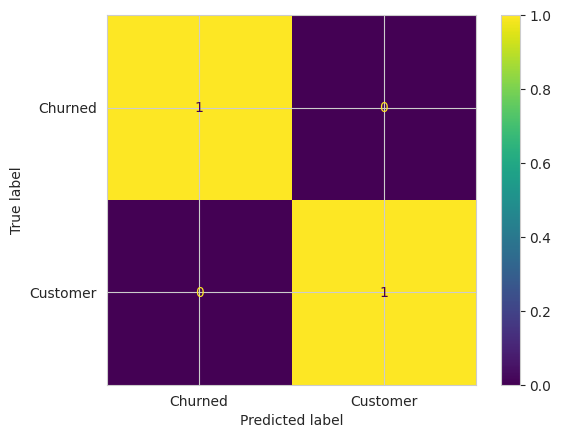

In [ ]:
#@markdown Checking confusion matrix for the random forest trained with defalt parameters
confusion_matrix_show_val(rf_)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(rf_, x_val)
fi[:40]


,cols,imp
254,Number of times contacted.1,0.070433
250,Number of Associated Deals.1,0.043219
234,Last Engagement Date.1,0.037404
341,Influ2 Aggregated Impressions,0.036902
240,Latest Source Timestamp,0.034539
233,Last Booked Meeting Date,0.026461
200,Usage,0.024006
270,Recent Deal Amount.1,0.023598
199,Sentiment,0.022736
216,Customer Success Engineer,0.020370


In [ ]:
#@markdown Evaluating the customized random forest
evaluate_model(rf_md14_mf12_cw28sw1)

Test set
              precision    recall  f1-score   support

           0       0.89      0.54      0.68       171
           1       0.47      0.86      0.61        80

    accuracy                           0.65       251
   macro avg       0.68      0.70      0.64       251
weighted avg       0.76      0.65      0.65       251

tn, fp, fn, tp:  93 78 11 69
Val set
              precision    recall  f1-score   support

           0       0.83      0.48      0.61       153
           1       0.51      0.85      0.64        98

    accuracy                           0.62       251
   macro avg       0.67      0.66      0.62       251
weighted avg       0.70      0.62      0.62       251

tn, fp, fn, tp:  73 80 15 83


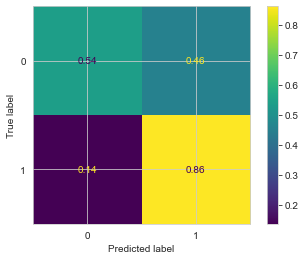

In [ ]:
#@markdown Checking confusion matrix
confusion_matrix_show_test(rf_md14_mf12_cw28sw1)

#####Model interpretation

In [ ]:
#@markdown Checking the features the customized algorithm uses for predictions
#TBD TO DEL?
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(rf_md14_mf12_cw28sw1, x_val)
fi[:40]

,cols,imp
63,Number of Employees.1,0.027381
59,Is Public,0.026029
65,Postal Code.1,0.025908
68,Street Address.1,0.023332
71,Website URL.1,0.022411
10,Job function,0.022274
72,Year Founded,0.022226
66,Region.1,0.021168
50,Company Domain Name,0.018865
52,Country/Region,0.018554


####XGB

In [ ]:
xgb_ = XGBClassifier()
xgb_.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
evaluate_model(xgb_)

Test set
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        86
           1       0.80      0.60      0.69        40

    accuracy                           0.83       126
   macro avg       0.82      0.77      0.78       126
weighted avg       0.82      0.83      0.82       126

tn, fp, fn, tp:  80 6 16 24
Val set
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        92
           1       0.87      0.77      0.82        35

    accuracy                           0.91       127
   macro avg       0.89      0.86      0.88       127
weighted avg       0.90      0.91      0.90       127

tn, fp, fn, tp:  88 4 8 27


In [ ]:
#@markdown Experimenting with extreme gradient boosting machine

xgb_ss06_md_6spw26_sw2_lr05 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.01, learning_rate=0.05, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=2.6, seed=0, subsample=0.6)
xgb_ss06_md_6spw26_sw2_lr05.fit(x_train, y_train, sample_weight=sw[2])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xgb_ss06_md_6spw26_sw2_lr05)

Test set
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        86
           1       0.68      0.75      0.71        40

    accuracy                           0.81       126
   macro avg       0.78      0.79      0.79       126
weighted avg       0.82      0.81      0.81       126

tn, fp, fn, tp:  72 14 10 30
Val set
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        92
           1       0.62      0.89      0.73        35

    accuracy                           0.82       127
   macro avg       0.78      0.84      0.80       127
weighted avg       0.86      0.82      0.83       127

tn, fp, fn, tp:  73 19 4 31


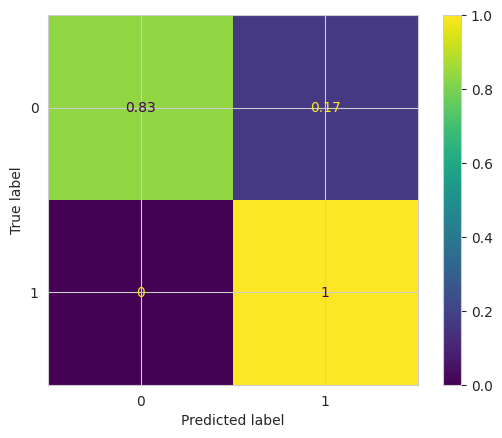

In [ ]:
#@markdown Checking confusion matrix
confusion_matrix_show_val(xgb_ss06_md_6spw26_sw2_lr05)

In [ ]:
#USED FOR PREDS JUN 19
#@markdown Experimenting with extreme gradient boosting machine

xgb_ss06_md_6spw28_sw2_lr05 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.01, learning_rate=0.05, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=2.8, seed=0, subsample=0.6)
xgb_ss06_md_6spw28_sw2_lr05.fit(x_train, y_train, sample_weight=sw[2])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xgb_ss06_md_6spw28_sw2_lr05)

Test set
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        86
           1       0.69      0.72      0.71        40

    accuracy                           0.81       126
   macro avg       0.78      0.79      0.78       126
weighted avg       0.81      0.81      0.81       126

tn, fp, fn, tp:  73 13 11 29
Val set
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        92
           1       0.62      0.89      0.73        35

    accuracy                           0.82       127
   macro avg       0.78      0.84      0.80       127
weighted avg       0.86      0.82      0.83       127

tn, fp, fn, tp:  73 19 4 31


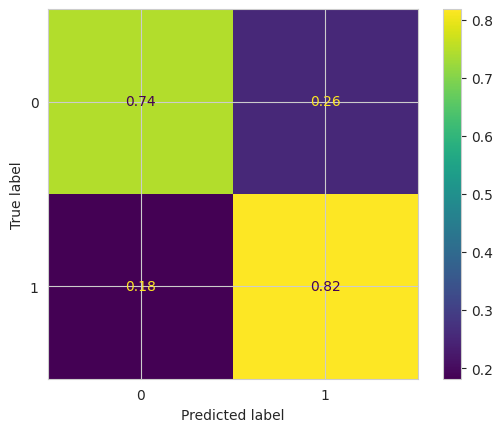

In [ ]:
confusion_matrix_show_val(xgb_ss06_md_6spw28_sw2_lr05)

In [ ]:
#USED FOR PREDS JULY 21 TO KEEP!!!
#@markdown Experimenting with extreme gradient boosting machine
#worked fine previously xgb_ss06_md_6spw29_sw3_lr03

xgb_ss06_md_6spw29_sw3_lr03 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.01, learning_rate=0.03, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=2.9, seed=0, subsample=0.6)
xgb_ss06_md_6spw29_sw3_lr03.fit(x_train, y_train, sample_weight=sw[3])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB with the test and validation datasets

evaluate_model(xgb_ss06_md_6spw29_sw3_lr03)

Test set
              precision    recall  f1-score   support

           0       0.89      0.77      0.82        86
           1       0.62      0.80      0.70        40

    accuracy                           0.78       126
   macro avg       0.75      0.78      0.76       126
weighted avg       0.80      0.78      0.78       126

tn, fp, fn, tp:  66 20 8 32
Val set
              precision    recall  f1-score   support

           0       0.96      0.76      0.85        92
           1       0.59      0.91      0.72        35

    accuracy                           0.80       127
   macro avg       0.78      0.84      0.78       127
weighted avg       0.86      0.80      0.81       127

tn, fp, fn, tp:  70 22 3 32


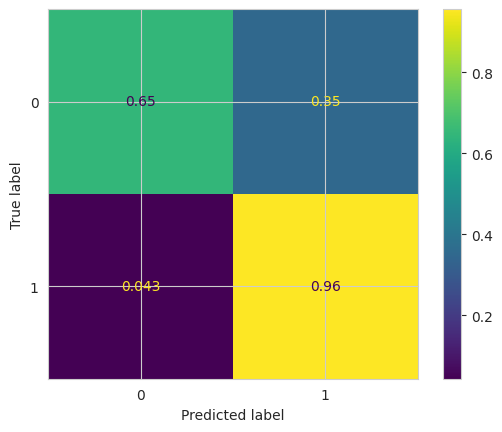

In [ ]:
confusion_matrix_show_test(xgb_ss06_md_6spw29_sw3_lr03)

In [ ]:
#ALTERNATIVE
#@markdown Experimenting with extreme gradient boosting machine
#worked fine previously xgb_ss06_md_6spw29_sw3_lr03

xgb_ss06_md_6spw34_sw4_lr03 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.01, learning_rate=0.03, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=3.4, seed=0, subsample=0.6)
xgb_ss06_md_6spw34_sw4_lr03.fit(x_train, y_train, sample_weight=sw[4])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB with the test and validation datasets

evaluate_model(xgb_ss06_md_6spw34_sw4_lr03)

Test set
              precision    recall  f1-score   support

           0       0.93      0.60      0.73        83
           1       0.48      0.88      0.62        34

    accuracy                           0.68       117
   macro avg       0.70      0.74      0.67       117
weighted avg       0.80      0.68      0.70       117

tn, fp, fn, tp:  50 33 4 30
Val set
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        84
           1       0.51      1.00      0.67        34

    accuracy                           0.72       118
   macro avg       0.75      0.80      0.71       118
weighted avg       0.86      0.72      0.73       118

tn, fp, fn, tp:  51 33 0 34


In [ ]:
#ATTEMPTS
#@markdown Experimenting with extreme gradient boosting machine
#worked fine previously xgb_ss06_md_6spw29_sw3_lr03

xgb_ss06_md_6spw29_sw2_lr03_g05 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.05, learning_rate=0.03, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=2.9, seed=0, subsample=0.6)
xgb_ss06_md_6spw29_sw2_lr03_g05.fit(x_train, y_train, sample_weight=sw[3])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.05, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB with the test and validation datasets

evaluate_model(xgb_ss06_md_6spw29_sw2_lr03_g05)

Test set
              precision    recall  f1-score   support

           0       0.93      0.63      0.75        83
           1       0.49      0.88      0.63        34

    accuracy                           0.70       117
   macro avg       0.71      0.75      0.69       117
weighted avg       0.80      0.70      0.71       117

tn, fp, fn, tp:  52 31 4 30
Val set
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        84
           1       0.52      1.00      0.68        34

    accuracy                           0.73       118
   macro avg       0.76      0.81      0.72       118
weighted avg       0.86      0.73      0.74       118

tn, fp, fn, tp:  52 32 0 34


In [ ]:
xgb_ss06_md_6spw36_sw4_lr03 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.01, learning_rate=0.03, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=3.6, seed=0, subsample=0.6)
xgb_ss06_md_6spw36_sw4_lr03.fit(x_train, y_train, sample_weight=sw[4])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB with the test and validation datasets

evaluate_model(xgb_ss06_md_6spw36_sw4_lr03)

Test set
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        84
           1       0.59      0.84      0.69        31

    accuracy                           0.80       115
   macro avg       0.76      0.81      0.77       115
weighted avg       0.84      0.80      0.81       115

tn, fp, fn, tp:  66 18 5 26
Val set
              precision    recall  f1-score   support

           0       0.97      0.80      0.87        83
           1       0.65      0.94      0.77        33

    accuracy                           0.84       116
   macro avg       0.81      0.87      0.82       116
weighted avg       0.88      0.84      0.84       116

tn, fp, fn, tp:  66 17 2 31


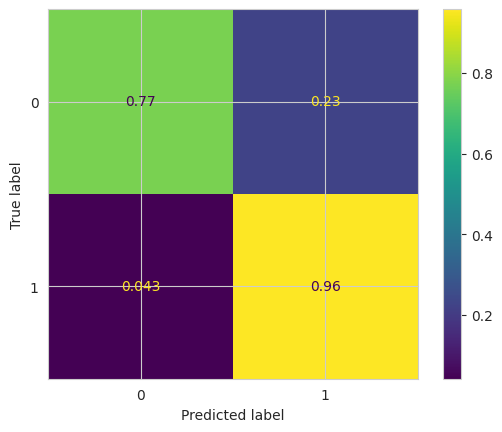

In [ ]:
#@markdown Checking confusion matrix
confusion_matrix_show_val(xgb_ss06_md_6spw29_sw3_lr03)

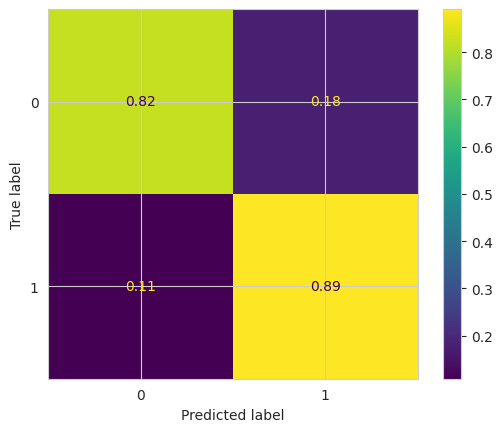

In [ ]:
confusion_matrix_show_test(xgb_ss06_md_6spw29_sw3_lr03)

ValueError: ignored

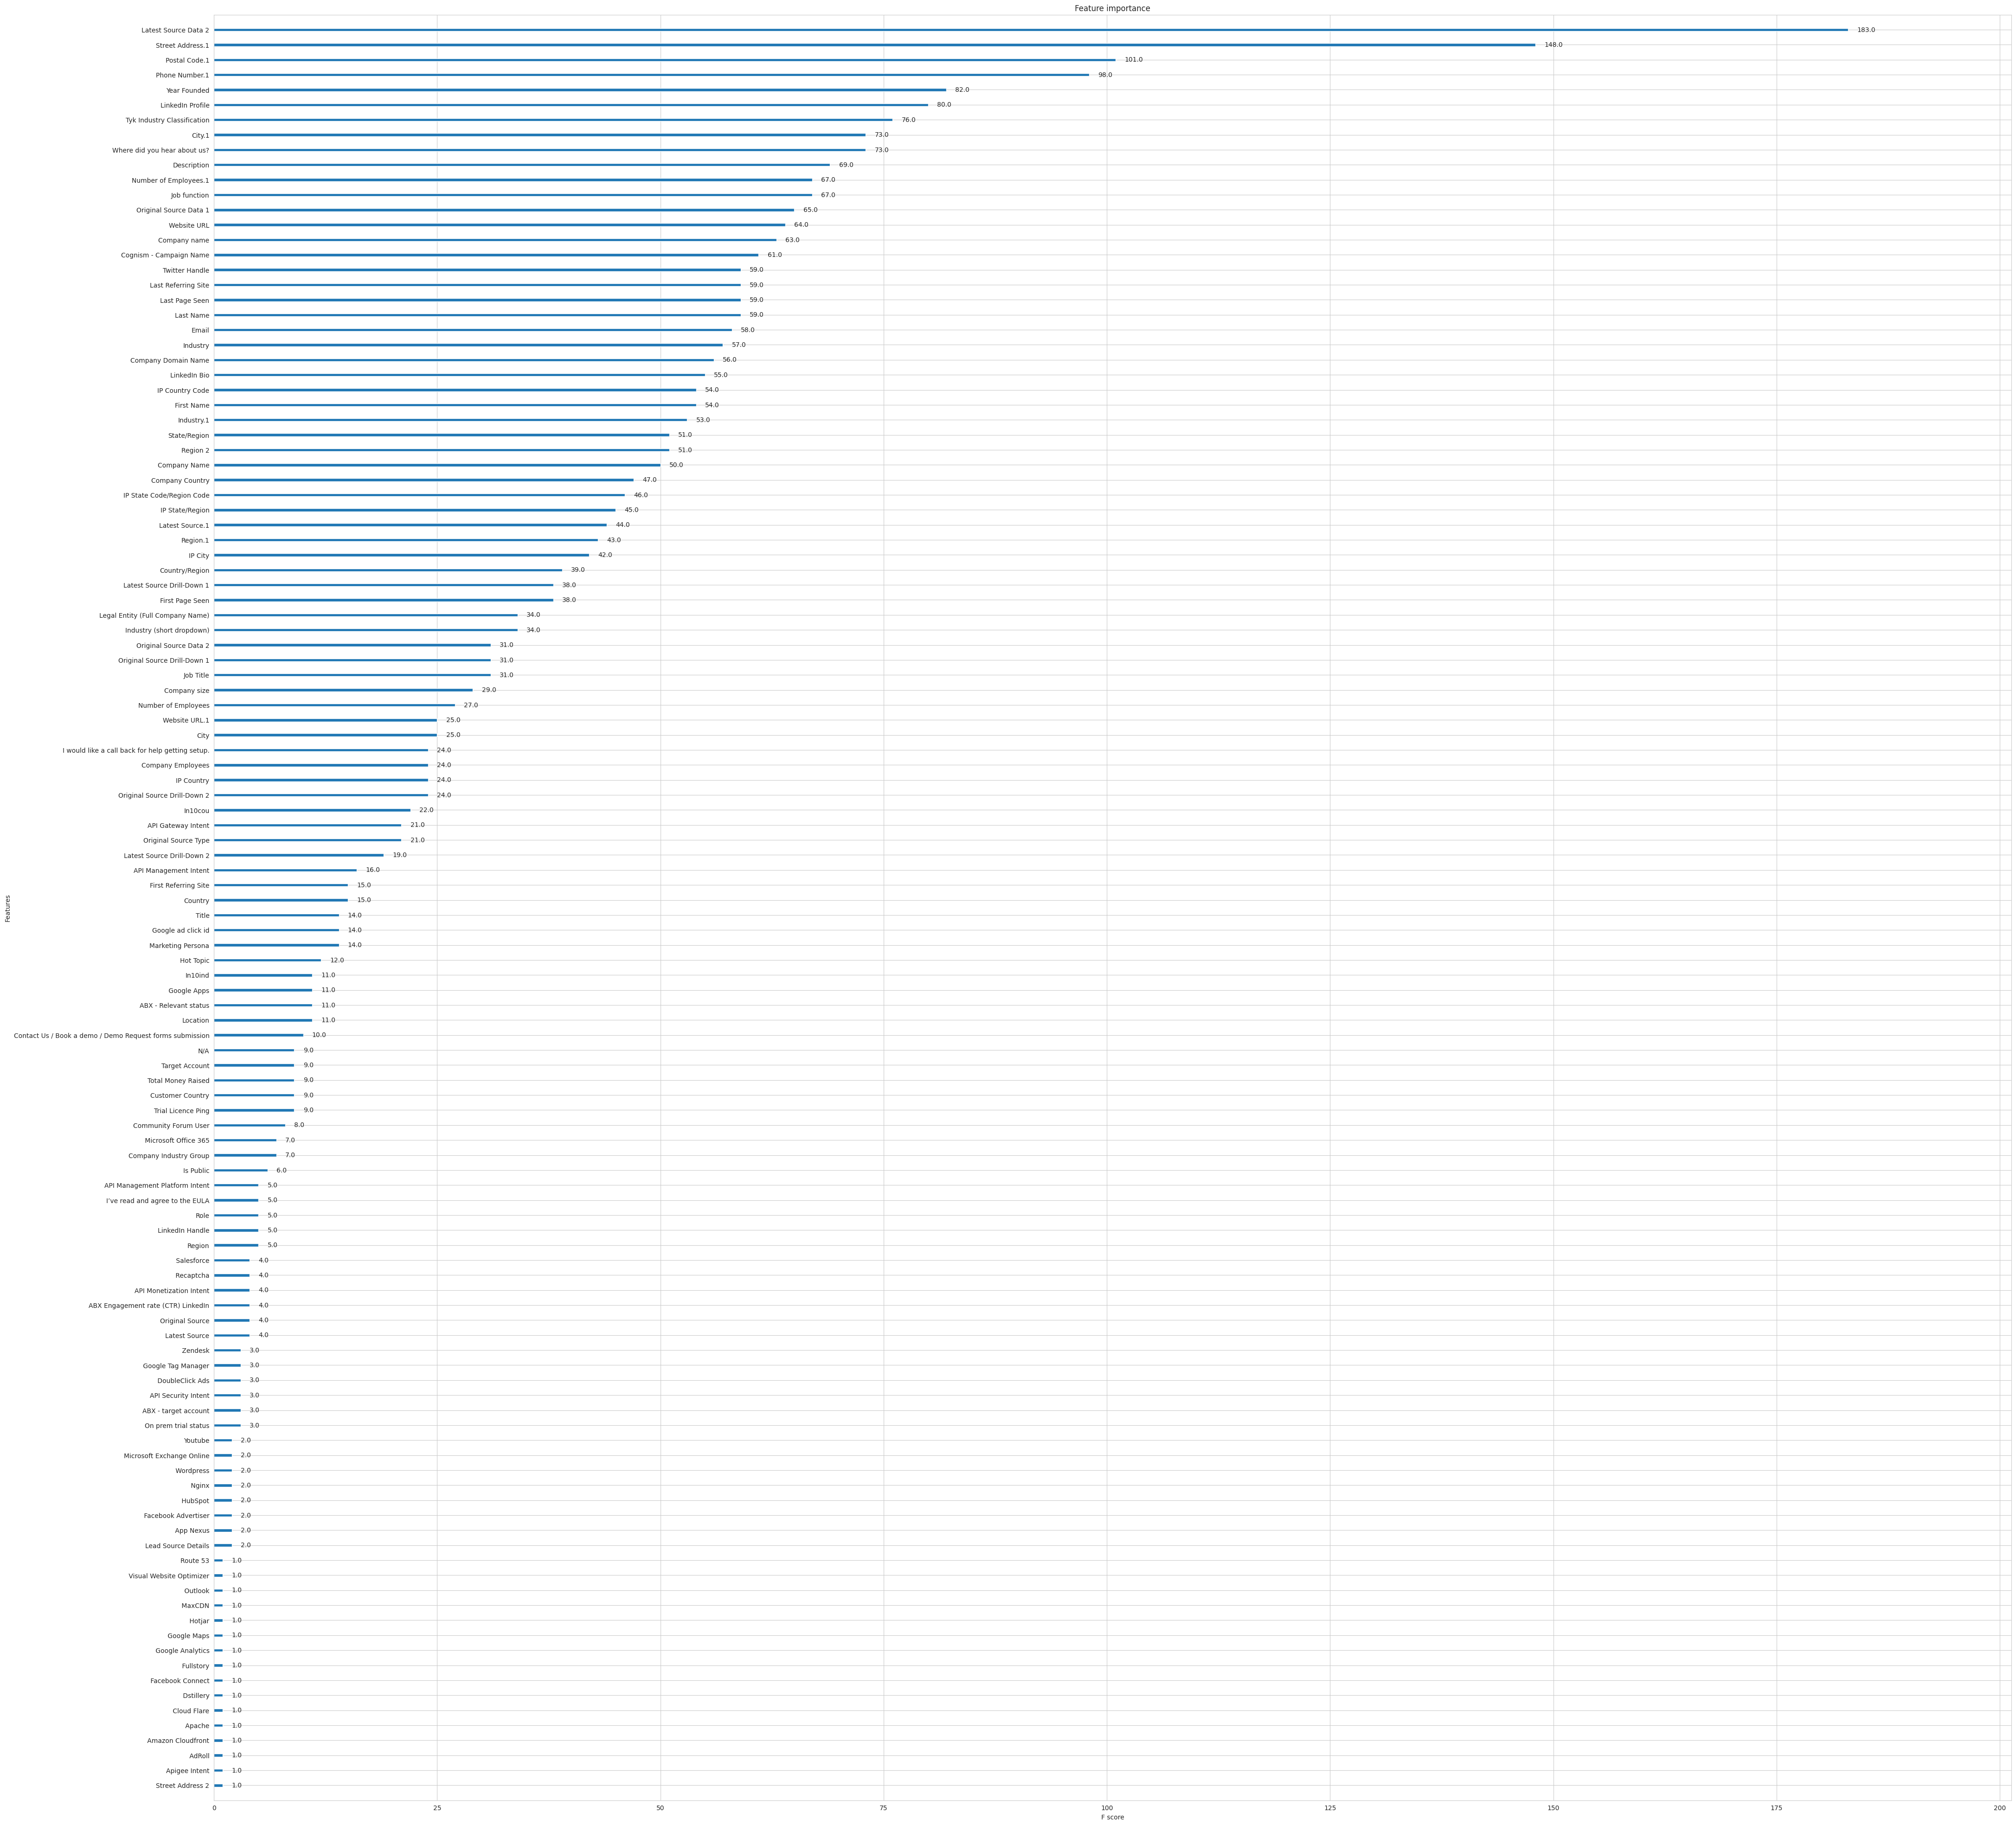

In [ ]:
#@markdown Analyzing the features used by XGB to predict
from xgboost import plot_importance#xgb_ss06_md_6spw29_sw3_lr03
fig, ax = plt.subplots(figsize=(50, 50))
imp = plot_importance(xgb_ss06_md_6spw29_sw3_lr03, ax = ax)
ax.set_yticklabels(xgb_ss06_md_6spw29_sw3_lr03.get_booster().feature_names)
ax.set_yticks(range(len(xgb_ss06_md_6spw29_sw3_lr03.get_booster().feature_names)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
xgb = XGBClassifier()
# Define hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0.01, 0.1, 1, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'scale_pos_weight': [2, 2.5, 2.8, 3, 3.4, 3.8, 4.2, 4.8]
}

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=100, cv=5,
                                   scoring='f1', verbose=1, n_jobs=-1)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Print the best hyperparameters found
print("Best parameters:", random_search.best_params_)

# Make predictions on the test set using the best model found
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate performance on test set
accuracy = np.mean(y_pred == y_test)
#f1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
#print("F1 score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.7, 'scale_pos_weight': 3.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1}
Accuracy: 0.8606060606060606
Precision: 0.7435897435897436
Recall: 0.6904761904761905


In [ ]:
#@markdown Updating XGB with parameters defined via grid search

xgb_ss07_md_6spw34_sw2_lr1_g1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=0.1, learning_rate=0.1, max_delta_step=0,max_depth=6,
                                            min_child_weight=6, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=3.4, seed=0, subsample=0.7)
xgb_ss07_md_6spw34_sw2_lr1_g1.fit(x_train, y_train, sample_weight=sw[2])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:

evaluate_model(xgb_ss07_md_6spw34_sw2_lr1_g1)

Test set
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       123
           1       0.75      0.89      0.81        46

    accuracy                           0.89       169
   macro avg       0.85      0.89      0.87       169
weighted avg       0.90      0.89      0.89       169

tn, fp, fn, tp:  109 14 5 41
Val set
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       123
           1       0.75      0.89      0.82        47

    accuracy                           0.89       170
   macro avg       0.85      0.89      0.87       170
weighted avg       0.90      0.89      0.89       170

tn, fp, fn, tp:  109 14 5 42


In [ ]:
xgb = XGBClassifier()
# Define hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0.01, 0.1, 1, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'scale_pos_weight': [2, 2.5, 2.8, 3]
}

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=100, cv=5,
                                   scoring='f1', verbose=1, n_jobs=-1)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Print the best hyperparameters found
print("Best parameters:", random_search.best_params_)

# Make predictions on the test set using the best model found
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate performance on test set
accuracy = np.mean(y_pred == y_test)
f1_score_ = metrics.f1_score(y_test, y_pred)#f1_score(y_test, y_pred)#
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1_score_)
print("Precision:", precision)
print("Recall:", recall)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.7, 'scale_pos_weight': 2.5, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 10}
Accuracy: 0.8087649402390438
F1 score: 0.7142857142857143
Precision: 0.6818181818181818
Recall: 0.75


In [ ]:
#TO
#@markdown Experimenting with extreme gradient boosting machine

xgb_ss07_md6_mcw5_spw34_sw3_g10_lr05 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                            gamma=10, learning_rate=0.05, max_delta_step=0,max_depth=6,
                                            min_child_weight=5, n_estimators=200,n_jobs=1,
                                            random_state=0,alpha=0, scale_pos_weight=3.4, seed=0, subsample=0.7)
xgb_ss07_md6_mcw5_spw34_sw3_g10_lr05.fit(x_train, y_train, sample_weight=sw[3])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xgb_ss07_md6_mcw5_spw34_sw3_g10_lr05)

Test set
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       171
           1       0.50      0.85      0.63        80

    accuracy                           0.68       251
   macro avg       0.70      0.73      0.67       251
weighted avg       0.77      0.68      0.69       251

tn, fp, fn, tp:  103 68 12 68
Val set
              precision    recall  f1-score   support

           0       0.89      0.52      0.65       153
           1       0.54      0.90      0.68        98

    accuracy                           0.67       251
   macro avg       0.72      0.71      0.66       251
weighted avg       0.75      0.67      0.66       251

tn, fp, fn, tp:  79 74 10 88


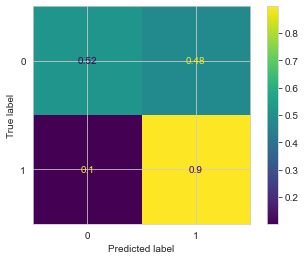

In [ ]:
#@markdown Checking confusion matrix
confusion_matrix_show_val(xgb_ss07_md6_mcw5_spw34_sw3_g10_lr05)

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xgb_ss07_md6_mcw5_spw25_sw3_g10_lr05)

Test set
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       171
           1       0.51      0.81      0.63        80

    accuracy                           0.69       251
   macro avg       0.70      0.72      0.68       251
weighted avg       0.76      0.69      0.70       251

tn, fp, fn, tp:  109 62 15 65
Val set
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       153
           1       0.53      0.87      0.66        98

    accuracy                           0.65       251
   macro avg       0.69      0.69      0.65       251
weighted avg       0.73      0.65      0.64       251

tn, fp, fn, tp:  77 76 13 85


In [ ]:
#Best parameters: {'subsample': 0.6, 'scale_pos_weight': 2, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 10}

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xgb_ss06_md_6spw29_sw3_lr01)

Test set
              precision    recall  f1-score   support

           0       0.88      0.37      0.52       171
           1       0.38      0.88      0.53        75

    accuracy                           0.53       246
   macro avg       0.63      0.63      0.53       246
weighted avg       0.73      0.53      0.53       246

tn, fp, fn, tp:  64 107 9 66
Val set
              precision    recall  f1-score   support

           0       0.86      0.35      0.49       156
           1       0.45      0.90      0.60        91

    accuracy                           0.55       247
   macro avg       0.65      0.62      0.54       247
weighted avg       0.71      0.55      0.53       247

tn, fp, fn, tp:  54 102 9 82


In [ ]:
xbg_ss06_md7_mcw10_spw3_lr05_ll = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1,
                                                gamma=0.01, learning_rate=0.05, max_delta_step=0,max_depth=7,
                                                min_child_weight=10, n_estimators=200,n_jobs=1,
                                                random_state=0,alpha=0, scale_pos_weight=3.0, seed=0, subsample=0.6,
                                                eval_metric='logloss')
xbg_ss06_md7_mcw10_spw3_lr05_ll.fit(x_train, y_train, sample_weight=sw[3])

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.01,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=7, max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#@markdown Evaluating the XGB on the test and validation datasets

evaluate_model(xbg_ss06_md7_mcw10_spw3_lr05_ll)

Test set
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       162
           1       0.54      0.87      0.67        84

    accuracy                           0.71       246
   macro avg       0.72      0.75      0.70       246
weighted avg       0.78      0.71      0.71       246

tn, fp, fn, tp:  101 61 11 73
Val set
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       147
           1       0.64      0.86      0.73       100

    accuracy                           0.74       247
   macro avg       0.76      0.76      0.74       247
weighted avg       0.78      0.74      0.75       247

tn, fp, fn, tp:  98 49 14 86


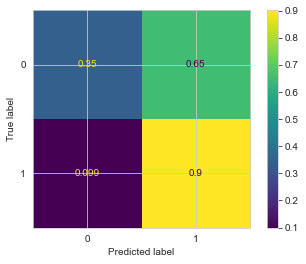

In [ ]:
#@markdown Checking confusion matrix
confusion_matrix_show_val(xgb_ss06_md_6spw29_sw3_lr01)

ValueError: The number of FixedLocator locations (122), usually from a call to set_ticks, does not match the number of ticklabels (411).

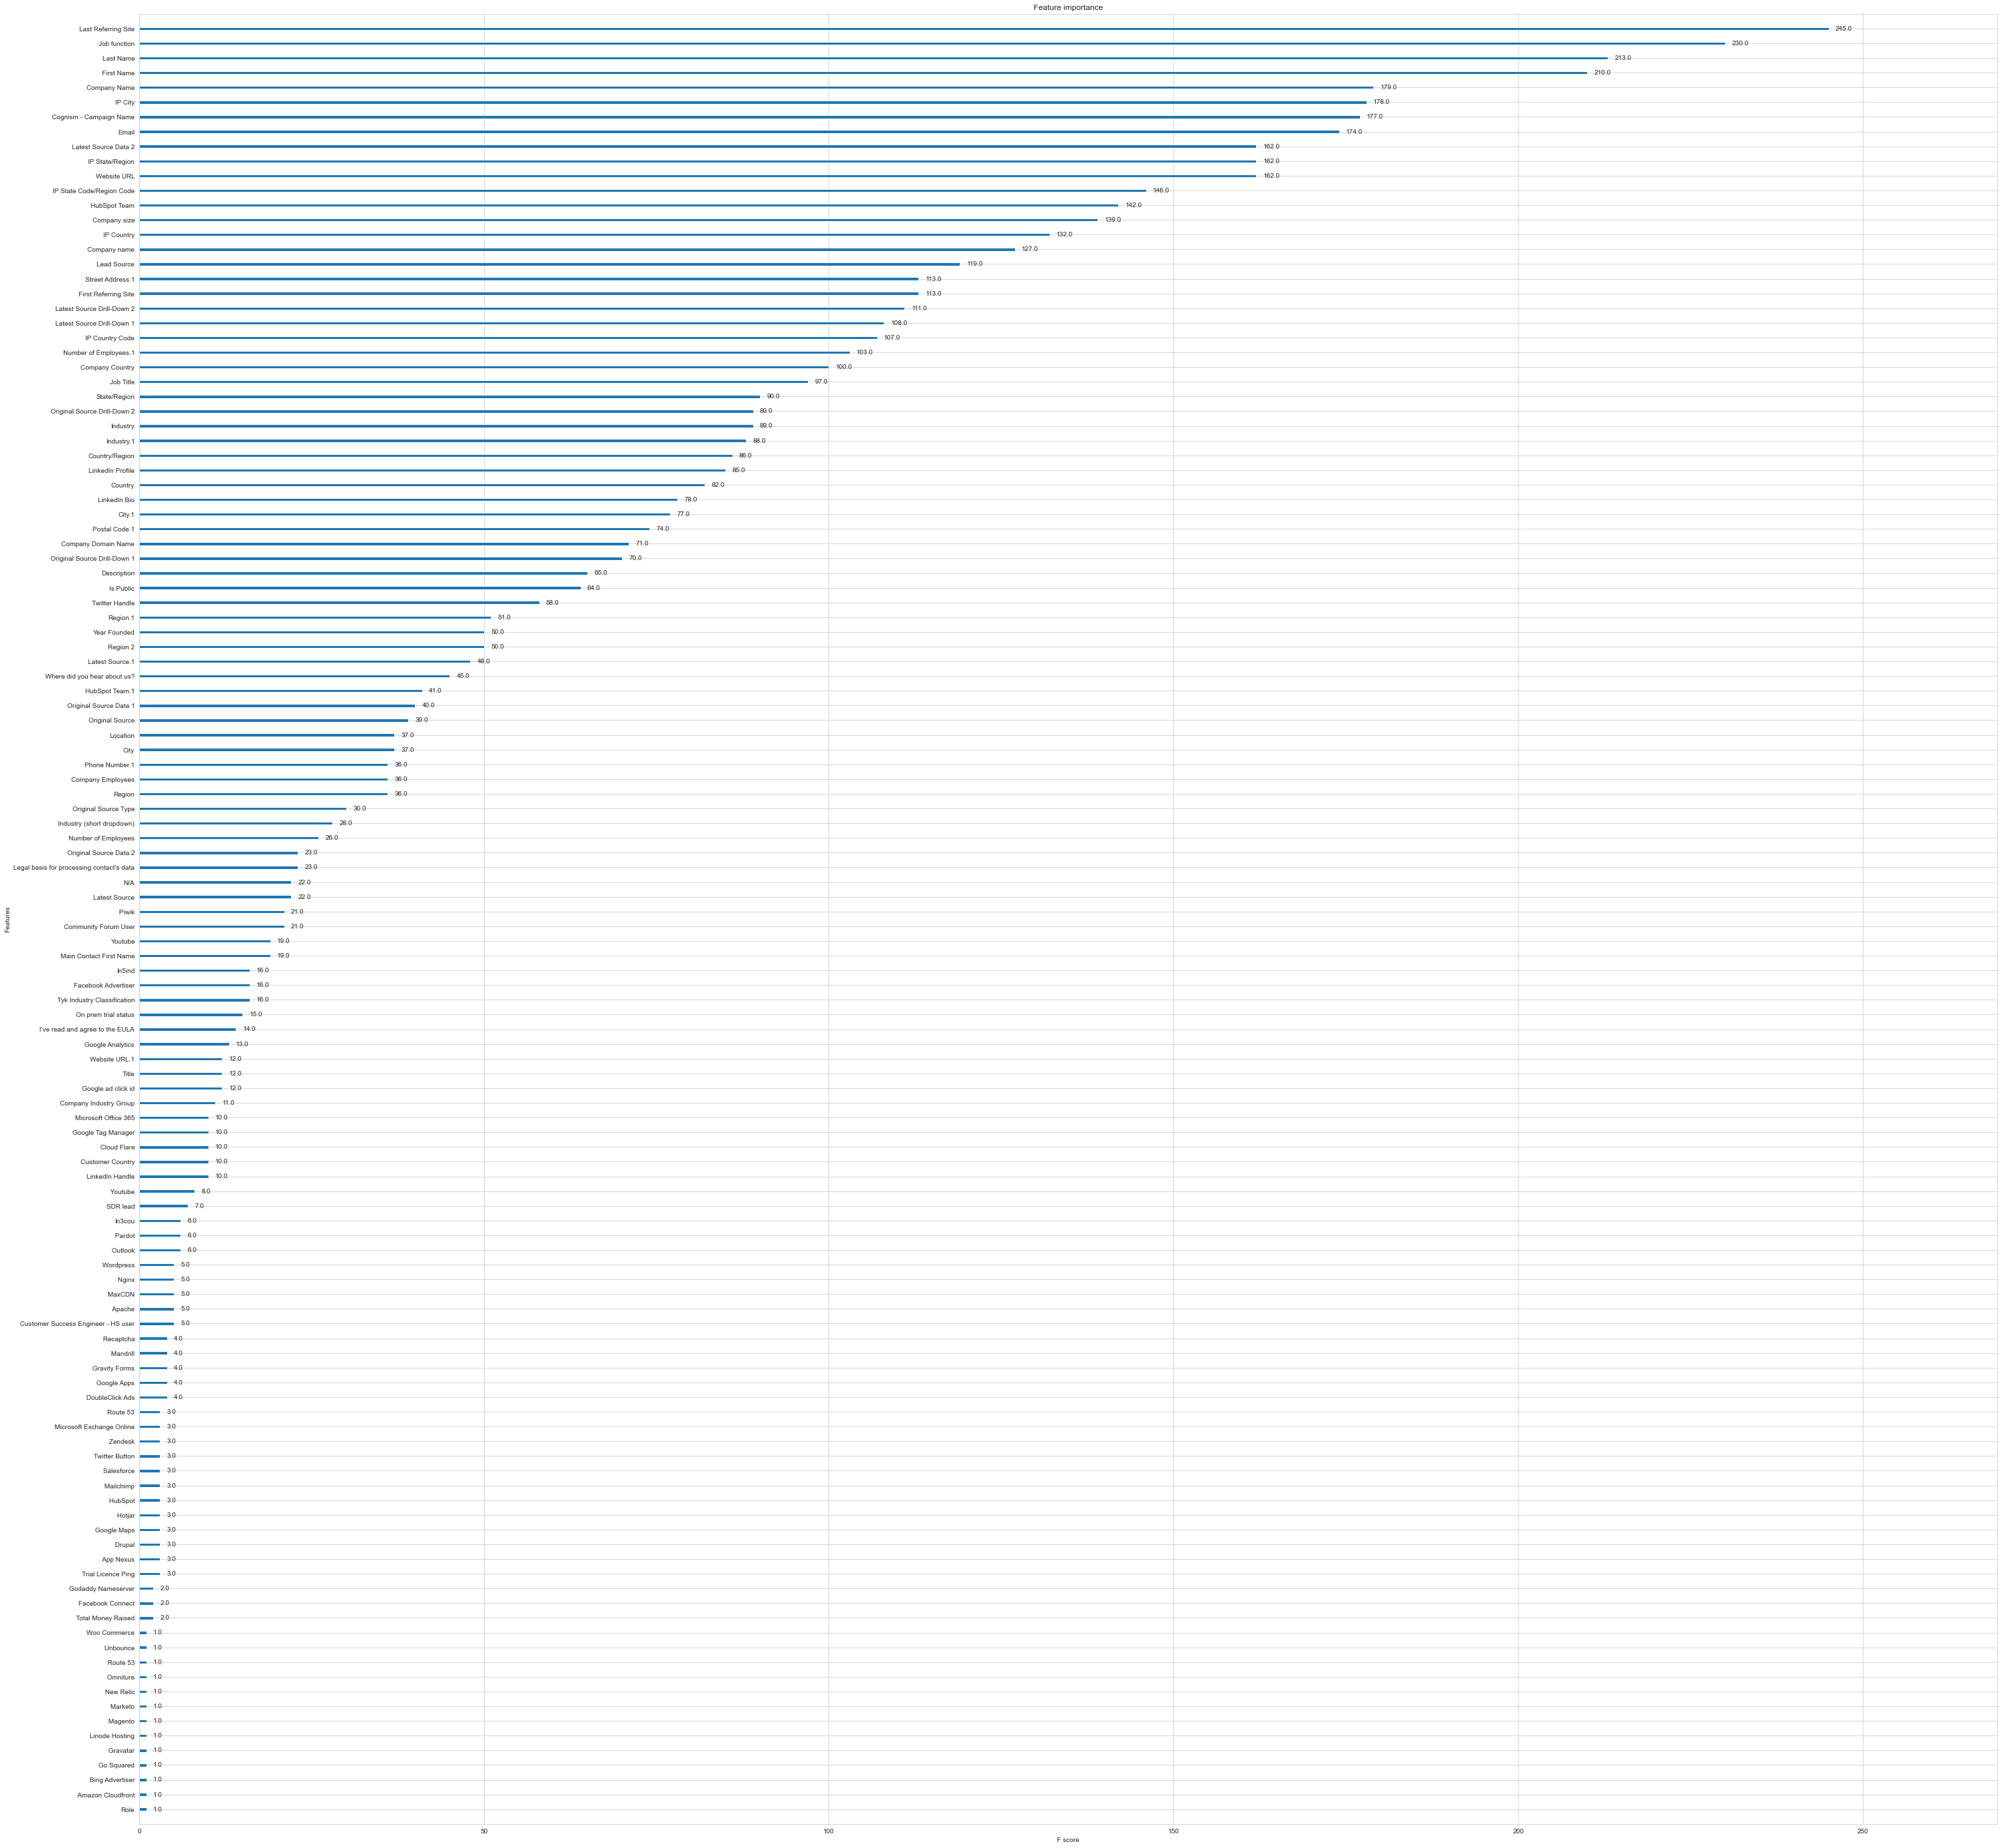

In [ ]:
#@markdown Analyzing the features used by XGB to predict
from xgboost import plot_importance
#'Contact unworked', 'Currently in worflow', 'Please' in col
fig, ax = plt.subplots(figsize=(50, 50))
plot_importance(xgb_ss06_md_7spw32_sw3_lr01, ax = ax).set_yticklabels(xgb_ss06_md_7spw32_sw3_lr01.get_booster().feature_names)

##Creating a contact list with predictions

In [ ]:
teback = ord_enc.inverse_transform(x[cat_cols_])
teback[:2]

array([['Idah', 'Kamau', 'N/A', 'N/A', 'n', 'N/A', 'N/A',
        'iddahkamau@gmail.com', 'N/A', 'N/A',
        'Information and Knowledge Management Specialist (InforMEA Initiative-Law Division)',
        'https://www.linkedin.com/in/idah-kamau/', 'N/A',
        'Tech Influencer', 'Ended', 'EMEA', 'Africa', 'N/A', 'N/A',
        'N/A', 'https://tyk.io/sign-up/',
        'https://tyk.io/whitepapers/opinionated-guide-2023/',
        'https://tyk.io/', 'https://tyk.io/sign-up/', 'Direct Traffic',
        'tyk.io/', 'N/A', 'Direct Traffic', 'tyk.io/sign-up', 'N/A',
        'N/A', 'N/A', 'nairobi', 'kenya', 'ke', 'nairobi city', '30',
        'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
        'N/A', 'Yes', 'n', 'Nairobi', 'unep.org',
        'United Nations Environment Programme', 'Kenya', 'N/A',
        "The United Nations Environment Programme is responsible for coordinating the UN's environmental activities and assisting developing countries in implementing environme

In [ ]:
testback = pd.DataFrame(teback, columns = cat_cols_)#, index = x_test.index.copy()
testback[:2]

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,Industry,Job function,Job Title,LinkedIn Profile,Location,Marketing Persona,On prem trial status,Region,Region 2,SDR lead,Trial Licence Ping,Website URL,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Industry Group,LinkedIn Handle,Role,Title,ABX - target account,Contact Us / Book a demo / Demo Request forms submission,Hot Topic,I would like a call back for help getting setup.,I’ve read and agree to the EULA,Where did you hear about us?,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Description,Industry.1,Industry (short dropdown),Latest Source.1,Latest Source Data 2,Legal Entity (Full Company Name),Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Street Address 2,Total Money Raised,Tyk Industry Classification,Website URL.1,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type,Target Account,ABX - Relevant status
0,Idah,Kamau,N/A,N/A,n,N/A,N/A,iddahkamau@gmail.com,N/A,N/A,Information and Knowledge Management Specialist (InforMEA Initiative-Law Division),https://www.linkedin.com/in/idah-kamau/,N/A,Tech Influencer,Ended,EMEA,Africa,N/A,N/A,N/A,https://tyk.io/sign-up/,https://tyk.io/whitepapers/opinionated-guide-2023/,https://tyk.io/,https://tyk.io/sign-up/,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/sign-up,N/A,N/A,N/A,nairobi,kenya,ke,nairobi city,30,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,n,Nairobi,unep.org,United Nations Environment Programme,Kenya,N/A,The United Nations Environment Programme is responsible for coordinating the UN's environmental ...,International Affairs,GOVERNMENT_ADMINISTRATION,Direct Traffic,N/A,United Nations Environment Programme,+254-20-7621234,13651,EMEA,Nairobi County,900 17th St N W,GIGIRI,N/A,Research,https://www.unep.org/,The United Nations Environment Programme is responsible for coordinating the UN's environmental ...,UNEP,tyk.io/sign-up,N/A,Direct Traffic,N/A,N/A
1,Deepthi,AR,N/A,N/A,Bottomline Technologies,N/A,N/A,deepthi.ar@bottomline.com,N/A,N/A,N/A,N/A,N/A,N/A,Ended,APAC,Asia,N/A,N/A,N/A,https://tyk.io/docs/tyk-apis/tyk-portal-api/portal-configuration/,https://www.google.com/,https://tyk.io/docs/tyk-dashboard/open-policy-agent/,https://tyk.io/docs/tyk-dashboard/opa-rules/,Direct Traffic,tyk.io/docs/tyk-dashboard/open-policy-agent,N/A,Offline Sources,EMAIL,EMAIL,Yes,N/A,bengaluru,india,in,karnataka,ka,N/A,N/A,N/A,N/A,N/A,N/A,Yes,N/A,API Deployment; API Design; API Dev Portal; API Documentation; API Gateway; API Publishing; API ...,N/A,Yes,Website,Portsmouth,bottomline.com,Bottomline Technologies,United States,N/A,"By using this website, you agree with the use of cookies set for performance, statistical and ad...",Computer Software,INFORMATION_TECHNOLOGY_AND_SERVICES,Organic Search,GOOGLE,N/A,+1 603-436-0700,03801,Americas,NH,325 Corporate Drive,N/A,5M,N/A,bottomline.com,"By using this website, you agree with the use of cookies set for performance, statistical and ad...",bottomlinetech,IMPORT,12744599,Offline Sources,True,LeadF + LeadSift


In [ ]:
#Defining model to be used and generating predictions
model_ = xgb_ss06_md_6spw29_sw3_lr03#xgb_ss06_md_6spw28_sw2_lr05#xgb_ss06_md_6spw29_sw3_lr03
#xgb_ss06_md_6spw29_sw3_lr03#xgb_ss06_md_6spw34_sw4_lr03#xgb_ss06_md_6spw29_sw3_lr03
preds_ = model_.predict(x)

In [ ]:
confusion_matrix(y, preds_).ravel()

array([1178,  308,   11,  604])

In [ ]:
preds_te_pr = model_.predict_proba(x)

In [ ]:
testback['Labels'] = y
testback['Customxgb'] = preds_
testback[['Customxgb_Non-conversion_prob','Predictive scoring (on prem trialists)']] = preds_te_pr
#testback_pr_lbls = pd.merge(testback, test_preds_and_labels)
testback[:6]

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,Industry,Job function,Job Title,LinkedIn Profile,Location,Marketing Persona,On prem trial status,Region,Region 2,SDR lead,Trial Licence Ping,Website URL,First Page Seen,First Referring Site,Last Page Seen,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Industry Group,LinkedIn Handle,Role,Title,ABX - target account,Contact Us / Book a demo / Demo Request forms submission,Hot Topic,I would like a call back for help getting setup.,I’ve read and agree to the EULA,Where did you hear about us?,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Description,Industry.1,Industry (short dropdown),Latest Source.1,Latest Source Data 2,Legal Entity (Full Company Name),Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Street Address 2,Total Money Raised,Tyk Industry Classification,Website URL.1,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type,Target Account,ABX - Relevant status,Labels,Customxgb,Customxgb_Non-conversion_prob,Predictive scoring (on prem trialists)
0,Idah,Kamau,N/A,N/A,n,N/A,N/A,iddahkamau@gmail.com,N/A,N/A,Information and Knowledge Management Specialist (InforMEA Initiative-Law Division),https://www.linkedin.com/in/idah-kamau/,N/A,Tech Influencer,Ended,EMEA,Africa,N/A,N/A,N/A,https://tyk.io/sign-up/,https://tyk.io/whitepapers/opinionated-guide-2023/,https://tyk.io/,https://tyk.io/sign-up/,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/sign-up,N/A,N/A,N/A,nairobi,kenya,ke,nairobi city,30,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,n,Nairobi,unep.org,United Nations Environment Programme,Kenya,N/A,The United Nations Environment Programme is responsible for coordinating the UN's environmental ...,International Affairs,GOVERNMENT_ADMINISTRATION,Direct Traffic,N/A,United Nations Environment Programme,+254-20-7621234,13651,EMEA,Nairobi County,900 17th St N W,GIGIRI,N/A,Research,https://www.unep.org/,The United Nations Environment Programme is responsible for coordinating the UN's environmental ...,UNEP,tyk.io/sign-up,N/A,Direct Traffic,N/A,N/A,1,1,0.093285,0.906715
1,Deepthi,AR,N/A,N/A,Bottomline Technologies,N/A,N/A,deepthi.ar@bottomline.com,N/A,N/A,N/A,N/A,N/A,N/A,Ended,APAC,Asia,N/A,N/A,N/A,https://tyk.io/docs/tyk-apis/tyk-portal-api/portal-configuration/,https://www.google.com/,https://tyk.io/docs/tyk-dashboard/open-policy-agent/,https://tyk.io/docs/tyk-dashboard/opa-rules/,Direct Traffic,tyk.io/docs/tyk-dashboard/open-policy-agent,N/A,Offline Sources,EMAIL,EMAIL,Yes,N/A,bengaluru,india,in,karnataka,ka,N/A,N/A,N/A,N/A,N/A,N/A,Yes,N/A,API Deployment; API Design; API Dev Portal; API Documentation; API Gateway; API Publishing; API ...,N/A,Yes,Website,Portsmouth,bottomline.com,Bottomline Technologies,United States,N/A,"By using this website, you agree with the use of cookies set for performance, statistical and ad...",Computer Software,INFORMATION_TECHNOLOGY_AND_SERVICES,Organic Search,GOOGLE,N/A,+1 603-436-0700,03801,Americas,NH,325 Corporate Drive,N/A,5M,N/A,bottomline.com,"By using this website, you agree with the use of cookies set for performance, statistical and ad...",bottomlinetech,IMPORT,12744599,Offline Sources,True,LeadF + LeadSift,1,1,0.020236,0.979764
2,Martin,Frändén,N/A,N/A,SVA,N/A,Sweden,martin.franden@sva.se,N/A,N/A,N/A,N/A,N/A,N/A,Ended,EMEA,Europe,N/A,N/A,N/A,https://tyk.io/features/api-gateway/,N/A,https://tyk.io/,https://tyk.io/docs/tyk-cloud/using-custom-domains/,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/features/api-gateway,N/A,Yes,N/A,helsinki,finland,fi,uusimaa,18,N/A,Sweden,N/A,N/A,N/A,N/A,Yes,N/A,N/A,N/A,N/A,N/A,Uppsala,sva.se,SVA,Sweden,Sweden,"SVA främj

In [ ]:
testback_ = testback[testback['Labels']!=1]
testback.shape, testback_.shape

((2101, 80), (1486, 80))

In [ ]:
#testback_.drop(['Labels', 'Customxgb', 'Customxgb_Non-conversion_prob'], axis = 1)
testback_ = testback_[['First Name', 'Last Name','Email','Company Name','Predictive scoring (on prem trialists)']]
testback_.to_csv('/content/on-prem-trialists_preds.csv', index=False)

In [ ]:
testback_.shape

(1338, 5)

In [ ]:
testback_[:4]

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,Industry,Job function,Job Title,LinkedIn Profile,Location,On prem trial status,Region,Region 2,SDR lead,Website URL,First Page Seen,First Referring Site,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Industry Group,LinkedIn Handle,Role,Title,I’ve read and agree to the EULA,Where did you hear about us?,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Description,Industry.1,Industry (short dropdown),Latest Source.1,Latest Source Data 2,Main Contact First Name,Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Street Address 2,Total Money Raised,Tyk Industry Classification,Website URL.1,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type,Target Account,ABX - Relevant status,Labels,Customxgb,Customxgb_Non-conversion_prob,Customxgb_Conv_prob
1,Sam,Nolan,Washington,N/A,Maxresistance,N/A,United States,goodsam@maxresistance.com,Internet Software & Services,N/A,N/A,N/A,N/A,Ended,EMEA,Middle East,N/A,http://maxresistance.com,https://pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,https://tyk.io/get-started/,https://www.google.com/,Organic Search,Unknown keywords (SSL),GOOGLE,Direct Traffic,pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,N/A,N/A,N/A,toronto,canada,ca,ontario,on,N/A,United States,Software & Services,N/A,N/A,N/A,N/A,N/A,Washington,maxresistance.com,Max Resistance,United States,N/A,For like minded facebook members.,N/A,N/A,Organic Search,GOOGLE,N/A,N/A,20037,Americas,DC,2112 F Street Northwest,N/A,N/A,N/A,maxresistance.com,N/A,N/A,pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,N/A,Direct Traffic,N/A,N/A,0,0,0.725279,0.274721
2,Chan,Tai Man,N/A,N/A,Rachelnsteve,N/A,N/A,tyk@rachelnsteve.com,N/A,N/A,N/A,N/A,N/A,Ended,APAC,Asia,N/A,http://rachelnsteve.com,https://tyk.io/,N/A,http://localhost:3000/,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/,N/A,N/A,N/A,hong kong,hong kong,hk,hong kong,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,rachelnsteve.com,rachelnsteve.com,N/A,N/A,N/A,N/A,N/A,Direct Traffic,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,rachelnsteve.com,N/A,N/A,tyk.io/,N/A,Direct Traffic,N/A,N/A,0,0,0.963257,0.036743
3,vikas,Maurya,N/A,N/A,Cupbest,N/A,N/A,jejono1627@cupbest.com,N/A,developer,Software Developer,N/A,N/A,Ended,APAC,Asia,Naz - APAC - Yes,http://cupbest.com,https://tyk.io/docs/basic-config-and-security/security/dashboard/,https://www.google.co.in/,http://localhost:3000/,Referrals,localhost,localhost/,Organic Search,Unknown keywords (SSL),GOOGLE,N/A,N/A,N/A,india,in,uttar pradesh,up,N/A,India,N/A,N/A,N/A,N/A,Yes,internet,N/A,cupbest.com,Cupbest,N/A,N/A,N/A,N/A,N/A,Offline Sources,EMAIL,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,cupbest.com,N/A,N/A,Unknown keywords (SSL),GOOGLE,Organic Search,N/A,N/A,0,0,0.976025,0.023975
9,Manjeet,Gupta,N/A,N/A,Bel,N/A,N/A,manjeetgupta6@gmail.com,N/A,N/A,MRS,N/A,N/A,Ended,APAC,Asia,N/A,N/A,https://tyk.io/,https://www.google.com/,https://tyk.io/docs/planning-for-production/ensure-high-availability/,Direct Traffic,tyk.io/docs/planning-for-production/ensure-high-availability/service-discovery,N/A,Organic Search,Unknown keywords (SSL),GOOGLE,N/A,N/A,N/A,india,in,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,bel.co.in,Bel,India,N/A,N/A,N/A,N/A,Offline Sources,userId:25164347,N/A,N/A,N/A,APAC,N/A,N/A,N/A,N/A,N/A,bel.co.in,N/A,N/A,Unknown keywords (SSL),GOOGLE,Organic Search,N/A,N/A,0,0,0.541189,0.458811


In [ ]:
preds_te_pr.shape, type(preds_te_pr)

((246, 2), numpy.ndarray)

In [ ]:
test_preds_and_labels = pd.DataFrame(data = y, columns = ['Labels'], index = x.index.copy())
test_preds_and_labels[:3]

,Labels
986,1
1622,0
670,0


In [ ]:
test_preds_and_labels['Customxgb'] = preds_
test_preds_and_labels[['Customxgb_Non-conversion_prob','Customxgb_Conv_prob']] = preds_te_pr

In [ ]:
test_preds_and_labels[:25]

,Labels,Customxgb,Customxgb_Non-conversion_prob,Customxgb_Conv_prob
1708,0,0,0.713890,0.286110
2368,0,0,0.600305,0.399695
2771,0,0,0.799285,0.200715
710,1,0,0.727710,0.272290
2569,0,0,0.541516,0.458484
7,1,1,0.138207,0.861793
2273,0,0,0.614696,0.385304
945,1,1,0.415700,0.584300
429,1,1,0.207905,0.792095
906,1,1,0.301196,0.698804


In [ ]:
len(test_preds_and_labels[(test_preds_and_labels['Labels']==0)&(test_preds_and_labels['Customxgb']==0)])

64

In [ ]:
testback[:25]

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,HubSpot Team,Industry,I’ve read and agree to the EULA,Job function,Job Title,Lead Source,Legal basis for processing contact's data,LinkedIn Profile,Location,On prem trial status,Region,Region 2,SDR lead,Trial Licence Ping,Website URL,Where did you hear about us?,First Referring Site,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Industry Group,LinkedIn Handle,Role,Seniority,Title,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Customer Success Engineer - HS user,Description,HubSpot Team.1,Industry.1,Industry (short dropdown),Latest Source.1,Latest Source Data 2,Main Contact First Name,Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Total Money Raised,Tyk Industry Classification,Website URL.1,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type
0,Mohammad,Ayoub,Beirut,N/A,FOO,N/A,Lebanon,mfa70@mail.aub.edu,N/A,Higher Education,Yes,Software Developer,Software Developer,N/A,Performance of a contract,https://www.linkedin.com/in/mohammad-ayoub-a9b9131a6,"Beirut, Beirut, Lebanon",Ended,EMEA,Middle East,N/A,N/A,http://www.foo.mobi,internship,https://tyk.io/,https://www.google.com/,Organic Search,Unknown keywords (SSL),GOOGLE,Direct Traffic,tyk.io/sign-up,N/A,N/A,N/A,beirut,lebanon,lb,beirut,ba,N/A,Lebanon,N/A,N/A,N/A,N/A,N/A,Beirut,mail.aub.edu,AMERICAN UNIVERSITY OF BEIRUT,Lebanon,N/A,N/A,"The American University of Beirut, AUB, is a private, non-sectarian institution of higher learni...",N/A,Higher Education,EDUCATION_MANAGEMENT,Organic Search,GOOGLE,N/A,N/A,N/A,EMEA,Beirut Governorate,3 Dag Hammarskjold Plz,N/A,N/A,mail.aub.edu,"The American University of Beirut, AUB, is a private, non-sectarian institution of higher learni...",AUB_Lebanon,tyk.io/sign-up,N/A,Direct Traffic
1,Michael,Byrnes,N/A,N/A,Priceline,N/A,N/A,michael.byrnes+1@priceline.com,US New Biz,N/A,Yes,N/A,Principal Software Engineer,N/A,Freely given consent from contact,N/A,N/A,Ended,Americas,North America,N/A,N/A,N/A,Internal discussions,https://www.google.com/,https://tyk.io/docs/plugins/supported-languages/javascript-middleware/middleware-scripting-guide/,Direct Traffic,tyk.io/docs/universal-data-graph/datasources/graphql,N/A,Paid Search,tyk - main - search,tyk,N/A,Cj0KCQjwhLKUBhDiARIsAMaTLnFbPZv185tuPP7U8x5X6_Q9SXt0wxgUOhjAJtXd-5p--i4ralCafZwaAvDkEALw_wcB,merrick,united states,us,new york,ny,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Norwalk,priceline.com,Priceline,United States,United States,N/A,Priceline.com is an online travel agency for finding discount rates for travel-related purchases...,US New Biz,Computer Software,INFORMATION_TECHNOLOGY_AND_SERVICES,Direct Traffic,N/A,N/A,2032998000,06854,Americas,CT,425 Rte Cameron,77.3M,N/A,priceline.com,Priceline.com is an online travel agency for finding discount rates for travel-related purchases...,priceline,CONTACTS,CRM_UI,Offline Sources
2,Abdulrahman,Almutairi,N/A,N/A,Elmco,N/A,N/A,bumi3times@gmail.com,EMEA,N/A,N/A,Senior Engineer,Senior Software Developer,N/A,Freely given consent from contact,N/A,N/A,Ended,EMEA,Middle East,N/A,N/A,N/A,N/A,https://www.google.com,https://tyk.io/price-comparison/,Organic Search,Unknown keywords (SSL),GOOGLE,Organic Search,Unknown keywords (SSL),GOOGLE,N/A,N/A,riyadh,saudi arabia,sa,ar riyad,01,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,chris,chris,N/A,N/A,Student,N/A,N/A,chrisa0123456789@gmail.com,EMEA New Biz,N/A,Yes,Student,Intern,N/A,Freely given consent from contact,N/A,N/A,Ended,EMEA,Africa,N/A,N/A,N/A,Online,https://tyk.io/product/tyk-on-premises-free-editi

In [ ]:
#ser = test_preds_and_labels.iloc[:,0]
#type(ser), ser.shape

(pandas.core.series.Series, (246,))

In [ ]:

colus

['Labels', 'Customxgb', 'Customxgb_Non-conversion_prob', 'Customxgb_Conv_prob']

In [ ]:
#testback_pr_lbls= pd.concat([testback, test_preds_and_labels], axis=1)
#colus = test_preds_and_labels.columns.to_list()
testback['Labels'] = y
testback['Customxgb'] = preds_
testback[['Customxgb_Non-conversion_prob','Customxgb_Conv_prob']] = preds_te_pr
#testback_pr_lbls = pd.merge(testback, test_preds_and_labels)
testback[:6]

,First Name,Last Name,City,Cognism - Campaign Name,Company Name,Company size,Country,Email,Industry,Job function,Job Title,LinkedIn Profile,Location,On prem trial status,Region,Region 2,SDR lead,Website URL,First Page Seen,First Referring Site,Last Referring Site,Latest Source,Latest Source Drill-Down 1,Latest Source Drill-Down 2,Original Source,Original Source Drill-Down 1,Original Source Drill-Down 2,Community Forum User,Google ad click id,IP City,IP Country,IP Country Code,IP State/Region,IP State Code/Region Code,Lead Source Details,Company Country,Company Industry Group,LinkedIn Handle,Role,Title,I’ve read and agree to the EULA,Where did you hear about us?,City.1,Company Domain Name,Company name,Country/Region,Customer Country,Description,Industry.1,Industry (short dropdown),Latest Source.1,Latest Source Data 2,Main Contact First Name,Phone Number.1,Postal Code.1,Region.1,State/Region,Street Address.1,Street Address 2,Total Money Raised,Tyk Industry Classification,Website URL.1,LinkedIn Bio,Twitter Handle,Original Source Data 1,Original Source Data 2,Original Source Type,Target Account,ABX - Relevant status,Labels,Customxgb,Customxgb_Non-conversion_prob,Customxgb_Conv_prob
0,Eduard,Lazar,"finchley, london",N/A,Omnibright,N/A,United Kingdom,eduard@omnibright.co,N/A,N/A,CEO,N/A,N/A,N/A,EMEA,Europe,N/A,N/A,https://tyk.io/,N/A,https://github.com/TykTechnologies/tyk-gateway-docker,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/,N/A,N/A,N/A,N/A,united kingdom,gb,N/A,N/A,N/A,United Kingdom,N/A,N/A,N/A,N/A,N/A,N/A,London,omnibright.co,omnibright.co,United Kingdom,N/A,N/A,N/A,N/A,Direct Traffic,N/A,N/A,N/A,N3 2LJ,EMEA,Greater London,342 Regents Park Road,N/A,N/A,N/A,omnibright.co,N/A,N/A,tyk.io/,N/A,Direct Traffic,N/A,N/A,1,1,0.130423,0.869577
1,Sam,Nolan,Washington,N/A,Maxresistance,N/A,United States,goodsam@maxresistance.com,Internet Software & Services,N/A,N/A,N/A,N/A,Ended,EMEA,Middle East,N/A,http://maxresistance.com,https://pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,https://tyk.io/get-started/,https://www.google.com/,Organic Search,Unknown keywords (SSL),GOOGLE,Direct Traffic,pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,N/A,N/A,N/A,toronto,canada,ca,ontario,on,N/A,United States,Software & Services,N/A,N/A,N/A,N/A,N/A,Washington,maxresistance.com,Max Resistance,United States,N/A,For like minded facebook members.,N/A,N/A,Organic Search,GOOGLE,N/A,N/A,20037,Americas,DC,2112 F Street Northwest,N/A,N/A,N/A,maxresistance.com,N/A,N/A,pages.tyk.io/en/sign-up-for-tyk-on-prem-licence,N/A,Direct Traffic,N/A,N/A,0,0,0.725279,0.274721
2,Chan,Tai Man,N/A,N/A,Rachelnsteve,N/A,N/A,tyk@rachelnsteve.com,N/A,N/A,N/A,N/A,N/A,Ended,APAC,Asia,N/A,http://rachelnsteve.com,https://tyk.io/,N/A,http://localhost:3000/,Direct Traffic,tyk.io/,N/A,Direct Traffic,tyk.io/,N/A,N/A,N/A,hong kong,hong kong,hk,hong kong,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,rachelnsteve.com,rachelnsteve.com,N/A,N/A,N/A,N/A,N/A,Direct Traffic,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,rachelnsteve.com,N/A,N/A,tyk.io/,N/A,Direct Traffic,N/A,N/A,0,0,0.963257,0.036743
3,vikas,Maurya,N/A,N/A,Cupbest,N/A,N/A,jejono1627@cupbest.com,N/A,developer,Software Developer,N/A,N/A,Ended,APAC,Asia,Naz - APAC - Yes,http://cupbest.com,https://tyk.io/docs/basic-config-and-security/security/dashboard/,https://www.google.co.in/,http://localhost:3000/,Referrals,localhost,localhost/,Organic Search,Unknown keywords (SSL),GOOGLE,N/A,N/A,N/A,india,in,uttar pradesh,up,N/A,India,N/A,N/A,N/A,N/A,Yes,internet,N/A,cupbest.com,Cupbest,N/A,N/A,N/A,N/A,N/A,Offline Sources,EMAIL,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,cupbest.com,N/A,N/A,Unknown keywords (SSL),GOOGLE,Organic Search,N/A,N/A,0,0,0.976025,0.023975
4,Jonathan,Foster,N/A,N/A,Nextera Energy,N/A,N/A,jonathan.foster@nexteraenergy.com,N/A,N/A,N/A,N/A,N/A,Ended,Americas,North America,N/A,N/A,https://tyk.io/contact/,https://tyk.io/price-comparison/,https://tyk.io/sign-up/,Direct Traffic,tyk.io/sign-up,N/A,Direct Traffic,tyk.io/contact,N/A,N/A,N/A,miami

In [ ]:
#y_hats = model.predict(X_test)

#y_test['preds'] = y_hats

#df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)

In [ ]:
testback.shape

(251, 75)

In [ ]:
#@title Analysis of mistakes by the most important features used to make predictions
testback[(testback['Labels']==1)&(testback['Customxgb']==0)]['Last Referring Site'].value_counts()
#Job function, Company Name

https://hs-5898904.s.hubspotemail.net/     2
https://www.google.com/                    2
https://tyk.io/                            1
https://tyk.io/sign-up/                    1
https://tyk.io/price-comparison/           1
https://tyk.io/api-gateway/on-premises/    1
http://192.168.1.133:3000/                 1
https://tyk.io/open-source-api-gateway/    1
Name: Last Referring Site, dtype: int64

In [ ]:
testback[(testback['Labels']==1)&(testback['Customxgb']==0)]['Job function'].value_counts()

N/A                        4
Enterprise Architect       1
Back End Developer         1
Tech Leader                1
Senior Developer           1
CEO                        1
Cloud Native Consultant    1
Name: Job function, dtype: int64

In [ ]:
testback[(testback['Labels']==1)&(testback['Customxgb']==0)]['Company Name'].value_counts()
#Job function, Company Name

SnappSupply       1
Center-cube       1
HKONNECT          1
Sber              1
YD&S              1
Mxclip            1
OleiroSoftware    1
self-employed     1
Softylus          1
OSIsoft           1
Name: Company Name, dtype: int64

In [ ]:
testback[(testback['Labels']==1)&(testback['Customxgb']==0)]['Email'].value_counts()
#Job function, Company Name

aseel@softylus.com        1
s911675@gmail.com         1
info@center-cube.com      1
vamartynova@yandex.ru     1
kisita2002@yahoo.fr       1
mohsenabedy0@gmail.com    1
joey.douglas@gmail.com    1
oleiro87@gmail.com        1
villa136@hotmail.com      1
fixaceh881@mxclip.com     1
Name: Email, dtype: int64

This model relies on 'Last Referring Site' and 'Job function' properties too much and is prone to misclassification if the data is missing.

In [ ]:
len(testback[(testback['Labels']==0.)&(testback['Customxgb']==1.)]), testback.shape

(107, (246, 76))

In [ ]:
#@title Least confident false positives
testback[(testback['Labels']==0)&(testback['Customxgb']==1)&(testback['Customxgb_Conv_prob']<0.6)]['Job function'].value_counts()

N/A                                            23
CTO                                             2
Java Sde                                        1
Co-founder                                      1
Software developer                              1
Tech Manager                                    1
Developer                                       1
Software Architect                              1
Apprenti Informatique Industrielle              1
Senior Engineer                                 1
Lead                                            1
FullStack Developer | Web, Mobile & Desktop     1
Name: Job function, dtype: int64

###LGB

In [ ]:
import lightgbm as lgb
#TO CHECK https://python.hotexamples.com/examples/lightgbm/LGBMClassifier/fit/python-lgbmclassifier-fit-method-examples.html
#

In [ ]:
lgb_cw4_csbt5_mcw01_sw20_lr001 = lgb.LGBMClassifier(boosting_type='gbdt', class_weight={0:1, 1:4}, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=700, n_jobs=-1, num_leaves=26, objective='binary',
               random_state=28, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=12000, subsample_freq=0)#scale_pos_weight
lgb_cw4_csbt5_mcw01_sw20_lr001.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],verbose=20, sample_weight = sw[1])#,eval_metric='logloss')

[20]	training's binary_logloss: 0.36142	valid_0's binary_logloss: 1.17193
[40]	training's binary_logloss: 0.328965	valid_0's binary_logloss: 1.07001
[60]	training's binary_logloss: 0.303881	valid_0's binary_logloss: 0.995257
[80]	training's binary_logloss: 0.28422	valid_0's binary_logloss: 0.939795
[100]	training's binary_logloss: 0.267627	valid_0's binary_logloss: 0.898282
[120]	training's binary_logloss: 0.253565	valid_0's binary_logloss: 0.865399
[140]	training's binary_logloss: 0.240293	valid_0's binary_logloss: 0.832223
[160]	training's binary_logloss: 0.227905	valid_0's binary_logloss: 0.804624
[180]	training's binary_logloss: 0.217457	valid_0's binary_logloss: 0.781803
[200]	training's binary_logloss: 0.207258	valid_0's binary_logloss: 0.758606
[220]	training's binary_logloss: 0.198127	valid_0's binary_logloss: 0.736656
[240]	training's binary_logloss: 0.190197	valid_0's binary_logloss: 0.71932
[260]	training's binary_logloss: 0.182433	valid_0's binary_logloss: 0.700969
[280]	tr

LGBMClassifier(class_weight={0: 1, 1: 4}, colsample_bytree=0.5,
               learning_rate=0.01, min_child_weight=0.01, n_estimators=700,
               num_leaves=26, objective='binary', random_state=28, silent=True,
               subsample_for_bin=12000)

In [ ]:
evaluate_model(lgb_cw4_csbt5_mcw01_sw20_lr001)

Test set
              precision    recall  f1-score   support

           0       0.88      0.69      0.78       162
           1       0.58      0.82      0.68        84

    accuracy                           0.74       246
   macro avg       0.73      0.76      0.73       246
weighted avg       0.78      0.74      0.74       246

tn, fp, fn, tp:  112 50 15 69
Val set
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       147
           1       0.69      0.86      0.77       100

    accuracy                           0.79       247
   macro avg       0.79      0.80      0.79       247
weighted avg       0.81      0.79      0.79       247

tn, fp, fn, tp:  109 38 14 86


In [ ]:
evaluate_model(lgb_cw380_split_sw7_lr001)

Test set
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1644
           1       0.09      0.56      0.16        18

    accuracy                           0.94      1662
   macro avg       0.54      0.75      0.56      1662
weighted avg       0.99      0.94      0.96      1662

tn, fp, fn, tp:  1546 98 8 10
Val set
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1648
           1       0.13      0.80      0.22        15

    accuracy                           0.95      1663
   macro avg       0.56      0.88      0.60      1663
weighted avg       0.99      0.95      0.97      1663

tn, fp, fn, tp:  1568 80 3 12


In [ ]:
evaluate_model(lgb_cw360_split_sw5_lr001)

Test set
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1644
           1       0.07      0.56      0.13        18

    accuracy                           0.92      1662
   macro avg       0.53      0.74      0.54      1662
weighted avg       0.98      0.92      0.95      1662

tn, fp, fn, tp:  1520 124 8 10
Val set
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      1648
           1       0.11      0.87      0.19        15

    accuracy                           0.93      1663
   macro avg       0.55      0.90      0.58      1663
weighted avg       0.99      0.93      0.96      1663

tn, fp, fn, tp:  1539 109 2 13


In [ ]:
evaluate_model(lgb_cw340_split_sw3_lr001)

Test set
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1644
           1       0.08      0.61      0.15        18

    accuracy                           0.92      1662
   macro avg       0.54      0.77      0.55      1662
weighted avg       0.99      0.92      0.95      1662

tn, fp, fn, tp:  1524 120 7 11
Val set
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1648
           1       0.10      0.80      0.17        15

    accuracy                           0.93      1663
   macro avg       0.55      0.87      0.57      1663
weighted avg       0.99      0.93      0.96      1663

tn, fp, fn, tp:  1537 111 3 12


In [ ]:
#subsample_for_bin=200K
lgb_cw340_split_sw2_lr001

LGBMClassifier(class_weight={0: 1, 1: 340}, learning_rate=0.01,
               n_estimators=400, random_state=28)

In [ ]:
evaluate_model(lgb_cw340_split_sw2_lr001)

Test set
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1644
           1       0.09      0.67      0.17        18

    accuracy                           0.93      1662
   macro avg       0.55      0.80      0.56      1662
weighted avg       0.99      0.93      0.95      1662

tn, fp, fn, tp:  1529 115 6 12
Val set
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      1648
           1       0.11      0.87      0.19        15

    accuracy                           0.93      1663
   macro avg       0.55      0.90      0.58      1663
weighted avg       0.99      0.93      0.96      1663

tn, fp, fn, tp:  1540 108 2 13
